<div style="background-color: #007BFF; color: white; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif;">
    <h1 style="text-align: center; font-size: 28px;">Projet IML: Prediction of Building Energy 📊📈</h1>
    <p style="text-align: center; font-size: 18px;">Fait par :</p>
    <ul style="list-style-type: none; text-align: center; font-size: 18px; padding: 0;">
        <li>Mouhamed TRAORE</li>
        <li>Chaka KONE</li>
        <li>Papa Abdourahmane CISSE</li>
        <li>Moussa Diakhité</li>
    </ul>
    <p style="text-align: center; font-size: 18px; margin-top: 20px;">Sous la supervision de :</p>
    <p style="text-align: center; font-size: 18px;">Madame Mously DIAW</p>
</div>


<div style="background-color:blue;padding: 10px; border-radius: 10px; font-family: Arial, sans-serif;color:white;font-size:35px;"><u>Les packages</u></div>


In [147]:
from pathlib import Path
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots
from pivottablejs import pivot_ui
from scipy.stats import chi2_contingency
import xgboost
from xgboost import XGBRegressor
#from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot

<div style="background-color:blue;padding: 10px; border-radius: 10px; font-family: Arial, sans-serif;color:white;font-size:30px;"><u>Définition du repertoire de travail</u></div>


In [148]:
# définir le répertoire du projet contenant le dossier data/ et notebooks/
HOME = Path.cwd().parent
print(f"Home directory: {HOME}")

# définir le répertoire des données
DATA = Path(HOME, "data")
print(f"Data directory: {DATA}")

Home directory: c:\Users\HP\Desktop\ISE2_2024-2025\Environnement python\Building_Energy
Data directory: c:\Users\HP\Desktop\ISE2_2024-2025\Environnement python\Building_Energy\data


<div style="background-color:blue;padding: 10px; border-radius: 10px; font-family: Arial, sans-serif;color:white;font-size:30px;"><u>Importation des données</u></div>


In [149]:
data=pd.read_csv(Path(DATA, "Building_Energy.csv"), sep=",")
#data.head()


<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:30px; text-align: center;">
    <strong>Première Mission : Réalisation d'une Analyse Exploratoire</strong>
</div>


<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:30px; text-align: center;">
     <strong>1. Examen des données</strong>
</div>

In [150]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">
    <p><strong>Le dataset</strong> contient une série de colonnes représentant des informations sur les bâtiments, y compris l'identification (<code>OSEBuildingID</code>), les caractéristiques géographiques et d'usage (comme <code>BuildingType</code>, <code>PrimaryPropertyType</code>), ainsi que les adresses et codes postaux. Les mesures de consommation énergétique (<code>Electricity(kWh)</code>, <code>NaturalGas(therms)</code>, <code>TotalGHGEmissions</code>) et d'intensité d'émissions de gaz à effet de serre (<code>GHGEmissionsIntensity</code>) seront des éléments essentiels pour l'analyse.</p>
</div>


In [151]:
print('Nombre de doublons détecté : ',data.duplicated().sum())

Nombre de doublons détecté :  0


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Le dataset ne présente pas de doublons</div>

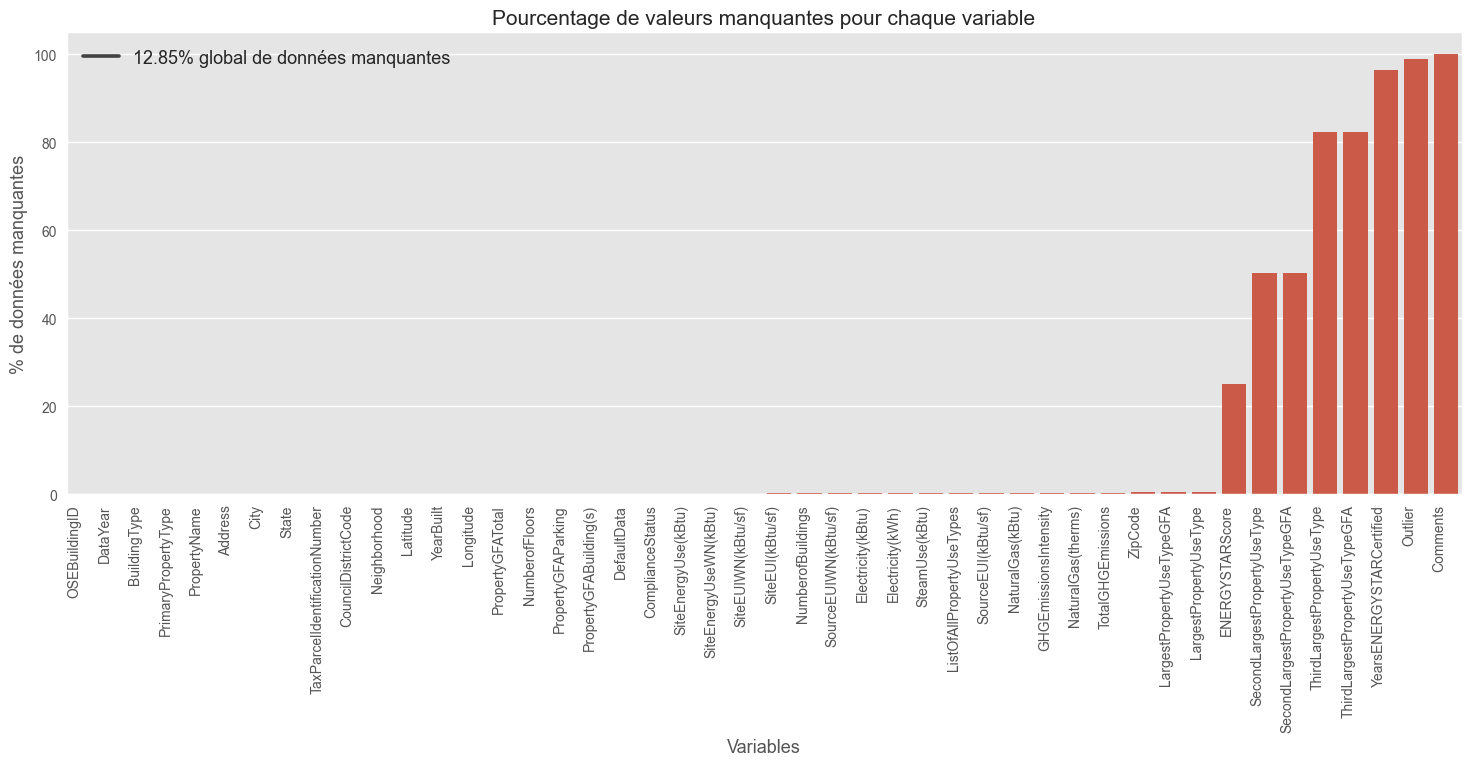

In [152]:
plt.figure(figsize=(18, 6))


null = data.isnull().sum(axis=0).sort_values() / len(data) * 100
null_prop = data.isnull().sum(axis=0).sum()/len(data)/len(data.columns)*100

sns.barplot(x=null.index, y=null.values)
plt.ylabel("% de données manquantes", fontsize=13)
plt.xlabel("Variables", fontsize=13)
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.title("Pourcentage de valeurs manquantes pour chaque variable", fontsize=15)
plt.legend(['{:.2f}% global de données manquantes'.format(null_prop)], fontsize=13)
plt.show()



<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Nous constatons que les variables relatives au type d’usage et à la superficie des deuxième et troisième plus grands usages des propriétés présentent des taux de valeurs manquantes (NA) assez élevés, dépassant même la moitié. Cependant, ces NA sont justifiés, car ils correspondent aux bâtiments ayant un seul usage possible. Nous conserverons ces variables dans notre analyse en remplaçant les NA par la modalité "Non Concerné" et en imputant les valeurs manquantes des superficies par 0.</div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:30px; text-align: center;">
     <strong>2. Nettoyage des données </strong>
</div>



<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Appliquons un nettoyage pour traiter les valeurs manquantes, les erreurs et les incohérences. Ce processus inclurait aussi la conversion des unités, la gestion des doublons et la standardisation des formats de variables (par exemple, passer les valeurs numériques en échelle log si nécessaire).</div>

In [153]:
data["BuildingType"].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Dans le cadre de ce projet, nous concentrons notre analyse sur les bâtiments à usage non résidentiel. Par conséquent, nous filtrerons la base de données en fonction de la variable BuildingType. Les catégories considérées comme non résidentielles sont : 'Nonresidential WA', 'SPS-District K-12', 'Campus', 'NonResidential', 'Nonresidential COS'.</div>

In [154]:
fil_data = data[data['BuildingType'].isin(['Nonresidential WA', 'SPS-District K-12', 'Campus', 'NonResidential', 'Nonresidential COS'])]
print(fil_data['BuildingType'].unique())
print('Dimensions de la base filtrée : ',fil_data.shape)

['NonResidential' 'Nonresidential COS' 'SPS-District K-12' 'Campus'
 'Nonresidential WA']
Dimensions de la base filtrée :  (1668, 46)


In [155]:
fil_data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Nous avons à présent une base constituée de <b>1668 batiments non destinés à l'habitation avec 46 variables</b>.</div>

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Les variables relatives au type d’usage et à la surface des deuxième et troisième plus grands usages des propriétés présentent des taux de valeurs manquantes (NA) assez élevés. Cependant, ces valeurs manquantes correspondent à des bâtiments n’ayant qu’un seul usage possible. Nous avons donc décidé de les conserver dans notre analyse en recodant les NA par la modalité <b>Non Concerné</b> et en remplaçant les valeurs manquantes des superficies par <b>0</b>.</div>

In [156]:
# Remplacement des NA de SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType et ThirdLargestPropertyUseTypeGFA

fil_data["SecondLargestPropertyUseType"].fillna("Non Concerné", inplace=True)
fil_data["SecondLargestPropertyUseTypeGFA"].fillna(0, inplace=True)
fil_data["ThirdLargestPropertyUseType"].fillna("Non Concerné", inplace=True)
fil_data["ThirdLargestPropertyUseTypeGFA"].fillna(0, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_4464\1970344111.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fil_data["SecondLargestPropertyUseType"].fillna("Non Concerné", inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_4464\1970344111.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_data["SecondLargestPropertyUseType"].fillna("

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Nous allons procéder à la récupération des variables à supprimer.</div>

In [157]:
# Création d'un DataFrame contenant la proportion de valeurs manquantes par variable
df = fil_data.isnull().sum()*100/len(fil_data)
df

OSEBuildingID                        0.000000
DataYear                             0.000000
BuildingType                         0.000000
PrimaryPropertyType                  0.000000
PropertyName                         0.000000
Address                              0.000000
City                                 0.000000
State                                0.000000
ZipCode                              0.959233
TaxParcelIdentificationNumber        0.000000
CouncilDistrictCode                  0.000000
Neighborhood                         0.000000
Latitude                             0.000000
Longitude                            0.000000
YearBuilt                            0.000000
NumberofBuildings                    0.119904
NumberofFloors                       0.000000
PropertyGFATotal                     0.000000
PropertyGFAParking                   0.000000
PropertyGFABuilding(s)               0.000000
ListOfAllPropertyUseTypes            0.119904
LargestPropertyUseType            

In [158]:
# Recupérons les variables avec un taux de valeurs manquantes de plus de 50%
threshold = 50
high_NA_vars = df[df > threshold].index.tolist()
high_NA_vars

['YearsENERGYSTARCertified', 'Comments', 'Outlier']

In [159]:
# Recupérons les variables dont toutes les modalités sont uniques
unique_modalities = fil_data.apply(lambda x: x.nunique())

unique_variables = unique_modalities[unique_modalities == len(fil_data)].index.tolist()

print("Variables dont toutes les modalités sont uniques:")
print(unique_variables)

Variables dont toutes les modalités sont uniques:
['OSEBuildingID']


In [160]:
# Recupérons les variable ayant une modalité
single_modal_vars = fil_data.apply(lambda col: col.nunique() == 1)

# Extraire les noms des colonnes avec une seule modalité
single_modal_vars = single_modal_vars[single_modal_vars].index.tolist()

print("Variables avec une seule modalité :")
print(single_modal_vars)

Variables avec une seule modalité :
['DataYear', 'City', 'State']


In [161]:
# Les variables à supprimer
var_ID = ['Address','TaxParcelIdentificationNumber','ZipCode','PropertyName']
vars_to_delete = high_NA_vars+single_modal_vars+unique_variables+var_ID
fil_data.drop(columns = vars_to_delete, inplace=True)



C:\Users\HP\AppData\Local\Temp\ipykernel_4464\3971838890.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_data.drop(columns = vars_to_delete, inplace=True)


In [162]:
fil_data.shape

(1668, 35)

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Nous avons maintenant une base composée de <b>1668 batiments non destinés à l'habitation avec 35 variables</b>.</div>

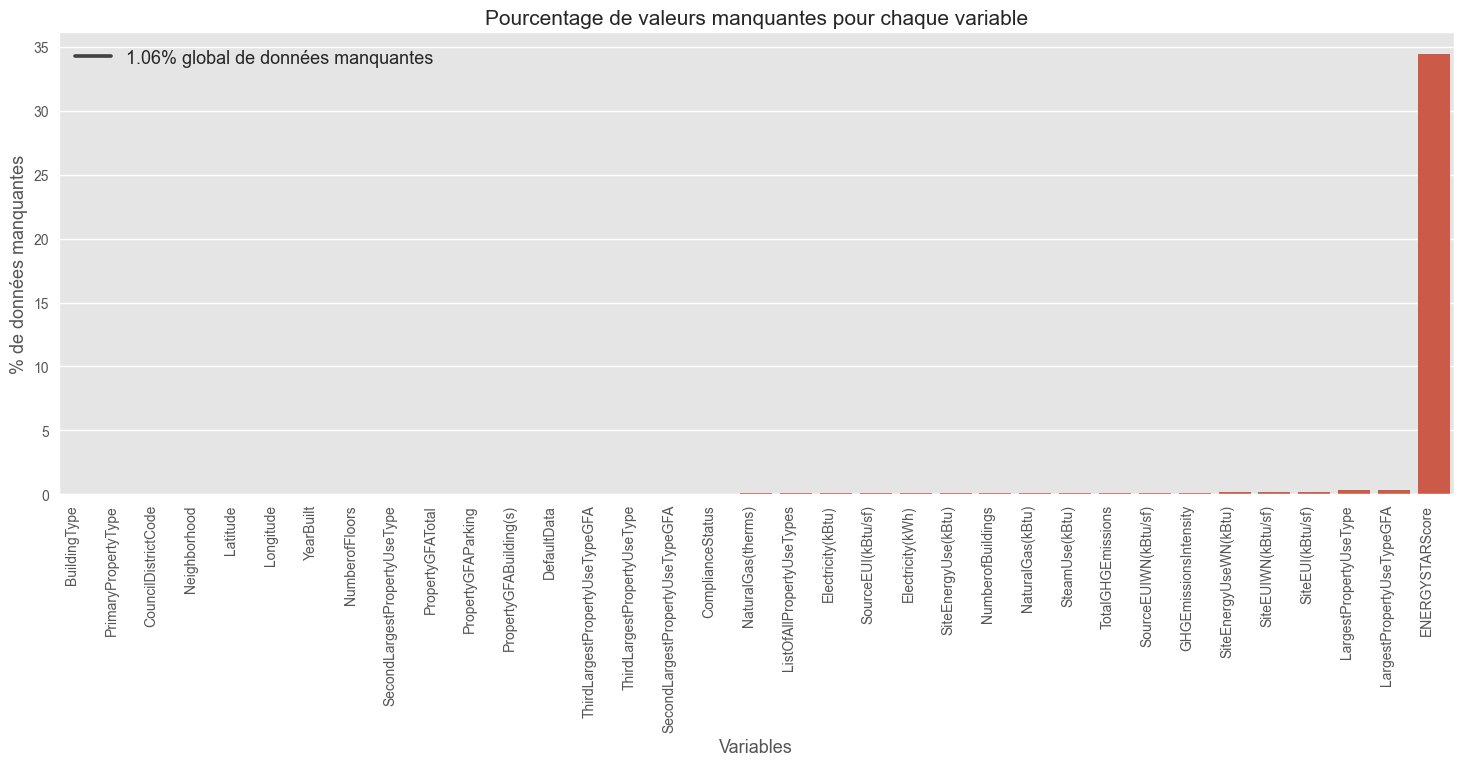

In [163]:
plt.figure(figsize=(18, 6))

null = fil_data.isnull().sum(axis=0).sort_values() / len(fil_data) * 100
null_prop = fil_data.isnull().sum(axis=0).sum()/len(fil_data)/len(fil_data.columns)*100

sns.barplot(x=null.index, y=null.values)
plt.ylabel("% de données manquantes", fontsize=13)
plt.xlabel("Variables", fontsize=13)
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.title("Pourcentage de valeurs manquantes pour chaque variable", fontsize=15)
plt.legend(['{:.2f}% global de données manquantes'.format(null_prop)], fontsize=13)
plt.show()


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Nous constatons que, mis à part la variable EnergyStarScore, les valeurs manquantes des autres variables sont très peu nombreuses. 
À ce stade, nous allons séparer les variables numériques et catégorielles dans des listes distinctes afin de les traiter différemment. Pour les variables numériques, nous prêterons une attention particulière aux valeurs négatives, que nous convertirons en NA avant de les imputer par leur médiane.</div>


In [164]:
num_columns = list(fil_data.select_dtypes(include=['float64', 'int64']).columns) # Variables numériques
obj_columns = list(fil_data.select_dtypes(include=['object', 'bool']).columns) # Variables catégorielles
obj_columns,num_columns

(['BuildingType',
  'PrimaryPropertyType',
  'Neighborhood',
  'ListOfAllPropertyUseTypes',
  'LargestPropertyUseType',
  'SecondLargestPropertyUseType',
  'ThirdLargestPropertyUseType',
  'DefaultData',
  'ComplianceStatus'],
 ['CouncilDistrictCode',
  'Latitude',
  'Longitude',
  'YearBuilt',
  'NumberofBuildings',
  'NumberofFloors',
  'PropertyGFATotal',
  'PropertyGFAParking',
  'PropertyGFABuilding(s)',
  'LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'ThirdLargestPropertyUseTypeGFA',
  'ENERGYSTARScore',
  'SiteEUI(kBtu/sf)',
  'SiteEUIWN(kBtu/sf)',
  'SourceEUI(kBtu/sf)',
  'SourceEUIWN(kBtu/sf)',
  'SiteEnergyUse(kBtu)',
  'SiteEnergyUseWN(kBtu)',
  'SteamUse(kBtu)',
  'Electricity(kWh)',
  'Electricity(kBtu)',
  'NaturalGas(therms)',
  'NaturalGas(kBtu)',
  'TotalGHGEmissions',
  'GHGEmissionsIntensity'])

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">La variable CouncilDistrictCode est normalement catégorielle nous allons la convertir et refaire le travail.</div>

In [165]:
fil_data["CouncilDistrictCode"] = fil_data["CouncilDistrictCode"].apply(str)
num_columns = list(fil_data.select_dtypes(include=['float64', 'int64']).columns)
obj_columns = list(fil_data.select_dtypes(include=['object', 'bool']).columns)
obj_columns,num_columns

C:\Users\HP\AppData\Local\Temp\ipykernel_4464\3177478698.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_data["CouncilDistrictCode"] = fil_data["CouncilDistrictCode"].apply(str)


(['BuildingType',
  'PrimaryPropertyType',
  'CouncilDistrictCode',
  'Neighborhood',
  'ListOfAllPropertyUseTypes',
  'LargestPropertyUseType',
  'SecondLargestPropertyUseType',
  'ThirdLargestPropertyUseType',
  'DefaultData',
  'ComplianceStatus'],
 ['Latitude',
  'Longitude',
  'YearBuilt',
  'NumberofBuildings',
  'NumberofFloors',
  'PropertyGFATotal',
  'PropertyGFAParking',
  'PropertyGFABuilding(s)',
  'LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'ThirdLargestPropertyUseTypeGFA',
  'ENERGYSTARScore',
  'SiteEUI(kBtu/sf)',
  'SiteEUIWN(kBtu/sf)',
  'SourceEUI(kBtu/sf)',
  'SourceEUIWN(kBtu/sf)',
  'SiteEnergyUse(kBtu)',
  'SiteEnergyUseWN(kBtu)',
  'SteamUse(kBtu)',
  'Electricity(kWh)',
  'Electricity(kBtu)',
  'NaturalGas(therms)',
  'NaturalGas(kBtu)',
  'TotalGHGEmissions',
  'GHGEmissionsIntensity'])

In [166]:
# DataFrame renseignant sur le nombre de valeurs manquantes et de valeurs négatives par variable
data_dict = {'Variable': [], 'Missing Values': [], 'Negative Values': []}
for label in num_columns:
    missing_values = fil_data[label].isna().sum()
    negative_values = sum(fil_data[label] < 0.0)
    data_dict['Variable'].append(label)
    data_dict['Missing Values'].append(missing_values)
    data_dict['Negative Values'].append(negative_values)
result_df = pd.DataFrame(data_dict)
print(result_df)

                           Variable  Missing Values  Negative Values
0                          Latitude               0                0
1                         Longitude               0             1668
2                         YearBuilt               0                0
3                 NumberofBuildings               2                0
4                    NumberofFloors               0                0
5                  PropertyGFATotal               0                0
6                PropertyGFAParking               0                0
7            PropertyGFABuilding(s)               0                0
8         LargestPropertyUseTypeGFA               6                0
9   SecondLargestPropertyUseTypeGFA               0                0
10   ThirdLargestPropertyUseTypeGFA               0                0
11                  ENERGYSTARScore             574                0
12                 SiteEUI(kBtu/sf)               3                0
13               SiteEUIWN(kBtu/sf

In [167]:
(fil_data['GHGEmissionsIntensity'] == 1000*fil_data['TotalGHGEmissions']/fil_data['PropertyGFATotal']).all()

np.False_

In [168]:
neg_cols = [col for col in num_columns if col != 'Longitude' and (fil_data[col] < 0).any()]
medians = fil_data[neg_cols].median()
for col in neg_cols:
    mask = (fil_data[col] < 0)
    fil_data.loc[mask, col] = medians[col]

In [169]:
data_dict = {'Variable': [], 'Missing Values': [], 'Negative Values': []}
for label in neg_cols:
    missing_values = fil_data[label].isna().sum()
    negative_values = sum(fil_data[label] < 0.0)
    data_dict['Variable'].append(label)
    data_dict['Missing Values'].append(missing_values)
    data_dict['Negative Values'].append(negative_values)
result_df = pd.DataFrame(data_dict)
print(result_df)

                Variable  Missing Values  Negative Values
0   SourceEUIWN(kBtu/sf)               2                0
1       Electricity(kWh)               2                0
2      Electricity(kBtu)               2                0
3      TotalGHGEmissions               2                0
4  GHGEmissionsIntensity               2                0


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Concentrons-nous maintenant sur les valeurs manquantes des colonnes autres que celles contenant des valeurs négatives. Pour ces colonnes, nous effectuerons une imputation en utilisant la médiane. Cependant, la variable ENERGYSTARScore fera l’objet d’un traitement spécifique, qui sera détaillé ultérieurement. </div>

In [170]:
numeric_cols_2 = [col for col in num_columns if col != 'ENERGYSTARScore']
for col in numeric_cols_2:
    median_value = fil_data[col].median()
    fil_data[col].fillna(median_value, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_4464\1201430114.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fil_data[col].fillna(median_value, inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_4464\1201430114.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_data[col].fillna(median_value, inplace=True)
C:\Users\HP\AppData\Local\Tem

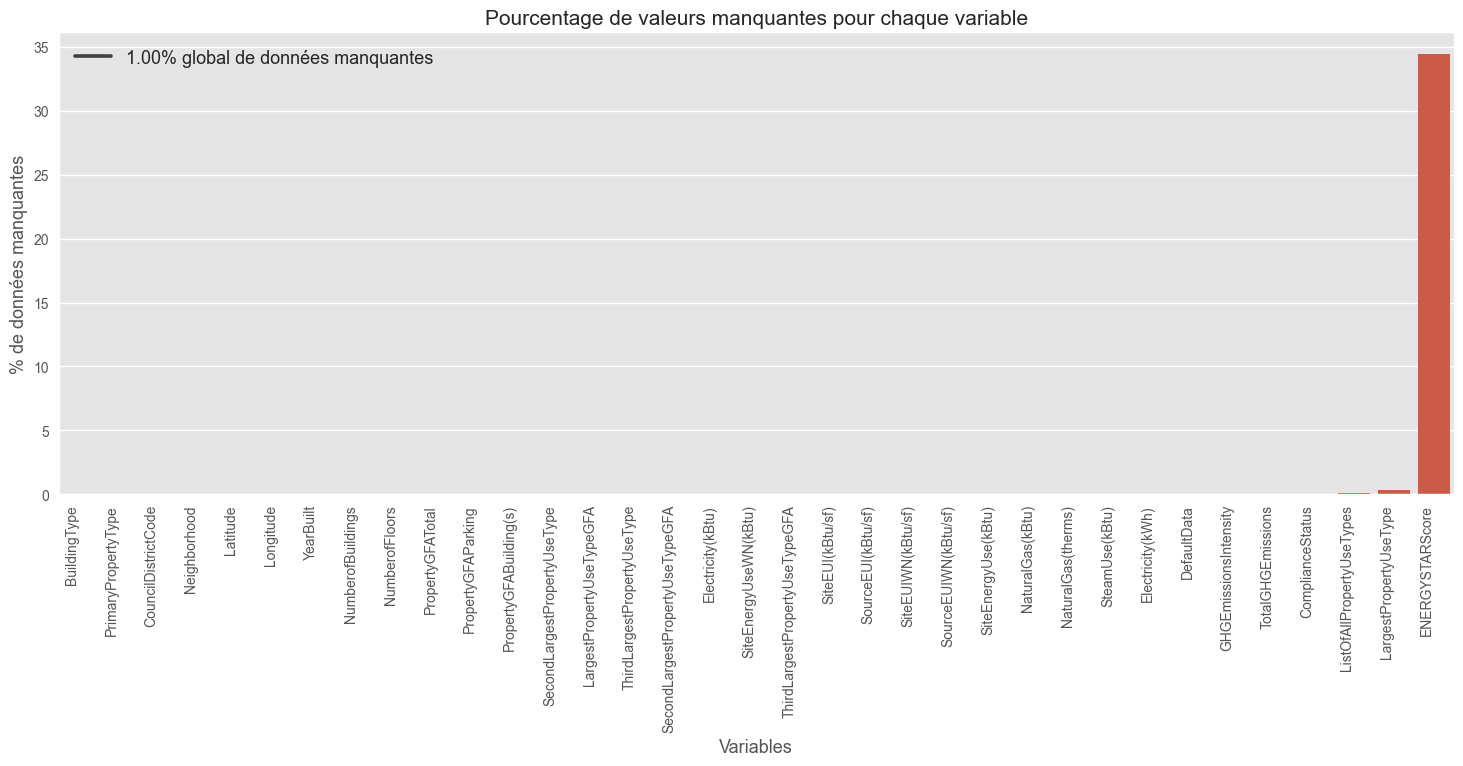

In [171]:
plt.figure(figsize=(18, 6))

null = fil_data.isnull().sum(axis=0).sort_values() / len(fil_data) * 100
null_prop = fil_data.isnull().sum(axis=0).sum()/len(fil_data)/len(fil_data.columns)*100

sns.barplot(x=null.index, y=null.values)
plt.ylabel("% de données manquantes", fontsize=13)
plt.xlabel("Variables", fontsize=13)
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.title("Pourcentage de valeurs manquantes pour chaque variable", fontsize=15)
plt.legend(['{:.2f}% global de données manquantes'.format(null_prop)], fontsize=13)
plt.show()


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Nous supprimerons uniquement les valeurs manquantes de la colonne LargestPropertyUseType.</div>

In [172]:
fil_data= fil_data.dropna(subset=[col for col in fil_data.columns if col != 'ENERGYSTARScore'], how='any')

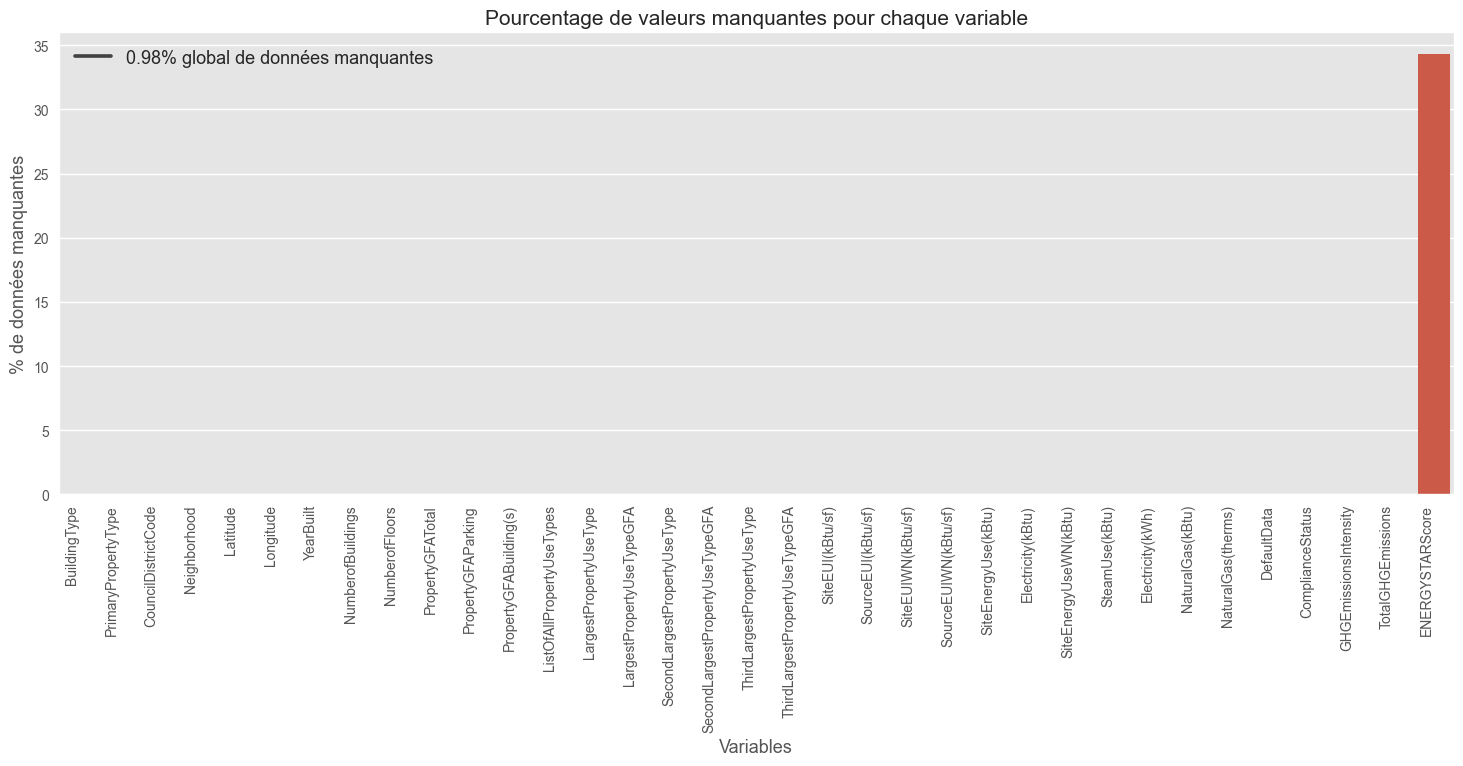

In [173]:
plt.figure(figsize=(18, 6))

null = fil_data.isnull().sum(axis=0).sort_values() / len(fil_data) * 100
null_prop = fil_data.isnull().sum(axis=0).sum()/len(fil_data)/len(fil_data.columns)*100

sns.barplot(x=null.index, y=null.values)
plt.ylabel("% de données manquantes", fontsize=13)
plt.xlabel("Variables", fontsize=13)
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.title("Pourcentage de valeurs manquantes pour chaque variable", fontsize=15)
plt.legend(['{:.2f}% global de données manquantes'.format(null_prop)], fontsize=13)
plt.show()


<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:30px; text-align: center;">
     <strong>3. Traitement des valeurs aberantes </strong>
</div> 

C:\Users\HP\AppData\Local\Temp\ipykernel_4464\2318809978.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fil_data[label], bins=int(1 + np.log2(len(fil_data))))
C:\Users\HP\AppData\Local\Temp\ipykernel_4464\2318809978.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fil_data[label], bins=i

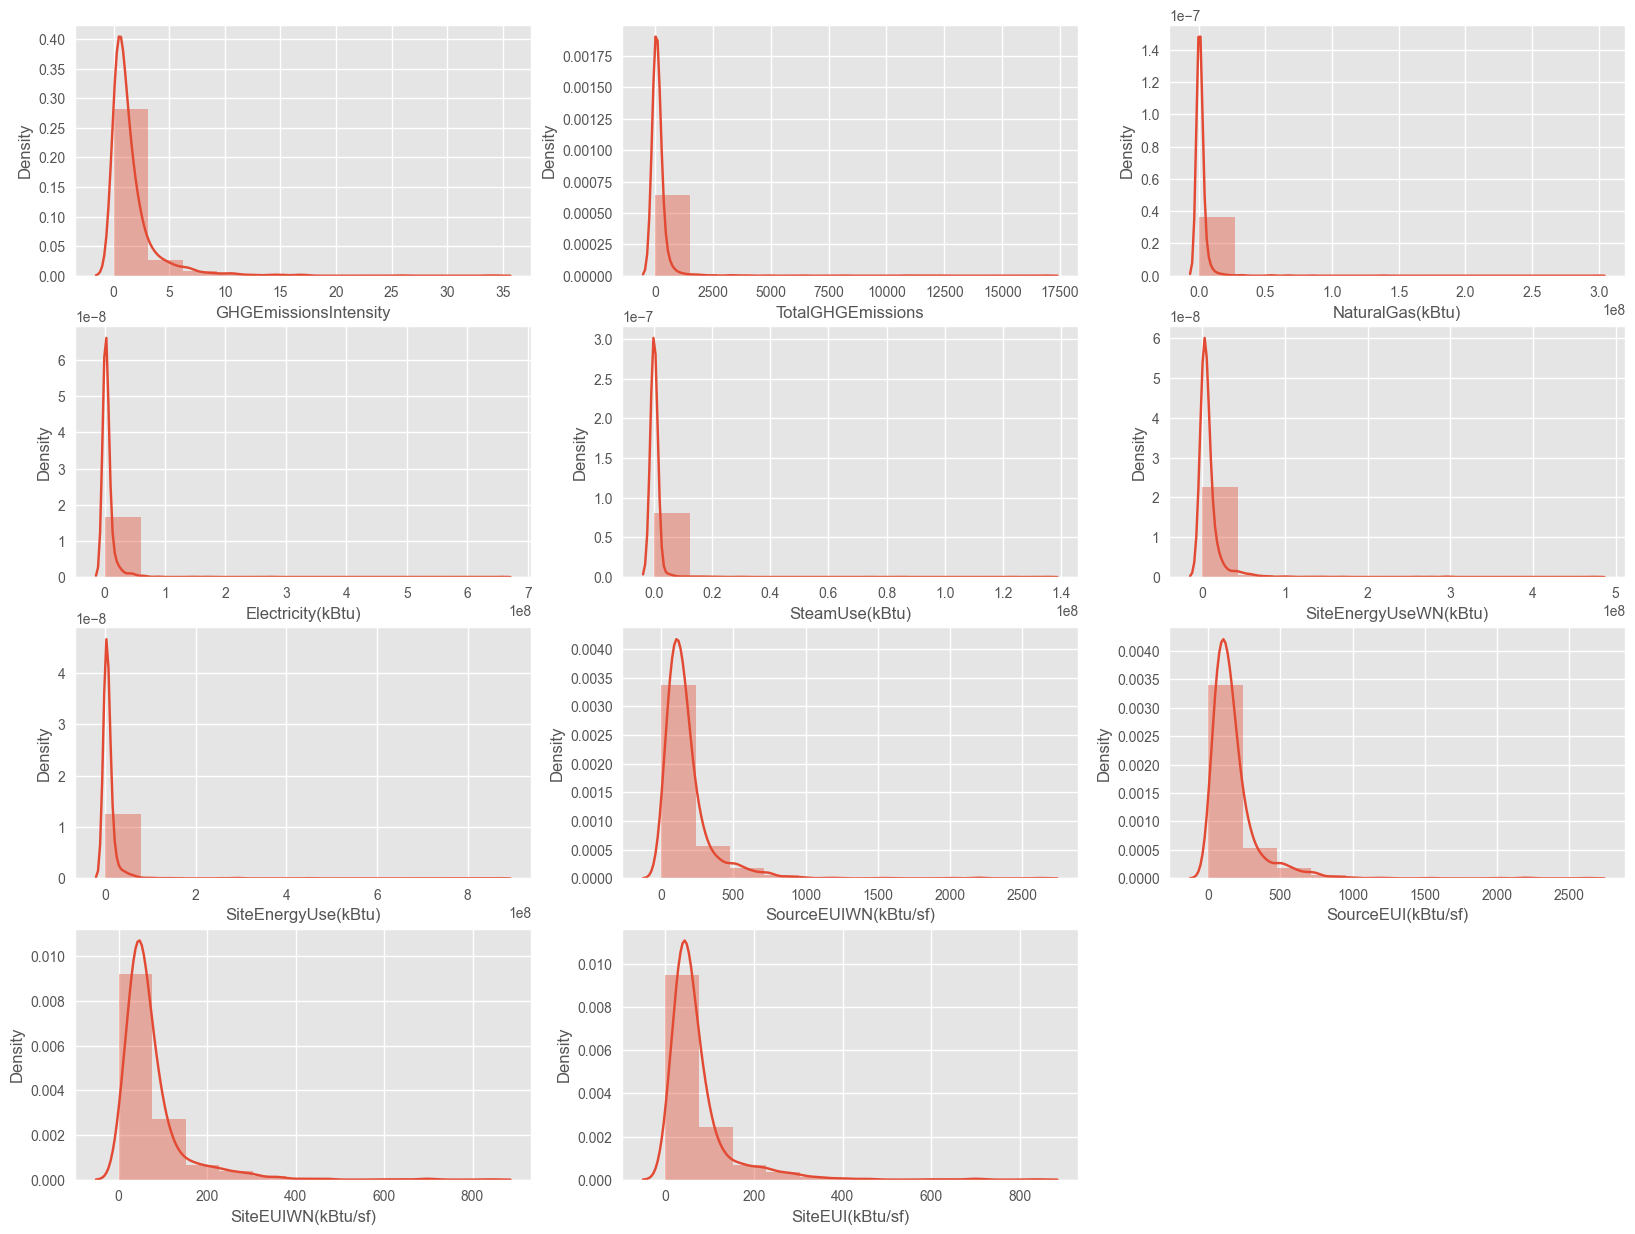

In [174]:
# Création d'un objet contenant toutes les variables liées à l'énergie
energy = ['GHGEmissionsIntensity','TotalGHGEmissions','NaturalGas(kBtu)','Electricity(kBtu)','SteamUse(kBtu)','SiteEnergyUseWN(kBtu)','SiteEnergyUse(kBtu)','SourceEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)',
          'SiteEUIWN(kBtu/sf)','SiteEUI(kBtu/sf)']
plt.style.use('ggplot')
fig = plt.figure(1, figsize=(20, 15))
for i, label in enumerate(energy) :
    plt.subplot(4, 3, i + 1)
    sns.distplot(fil_data[label], bins=int(1 + np.log2(len(fil_data))))
plt.show()

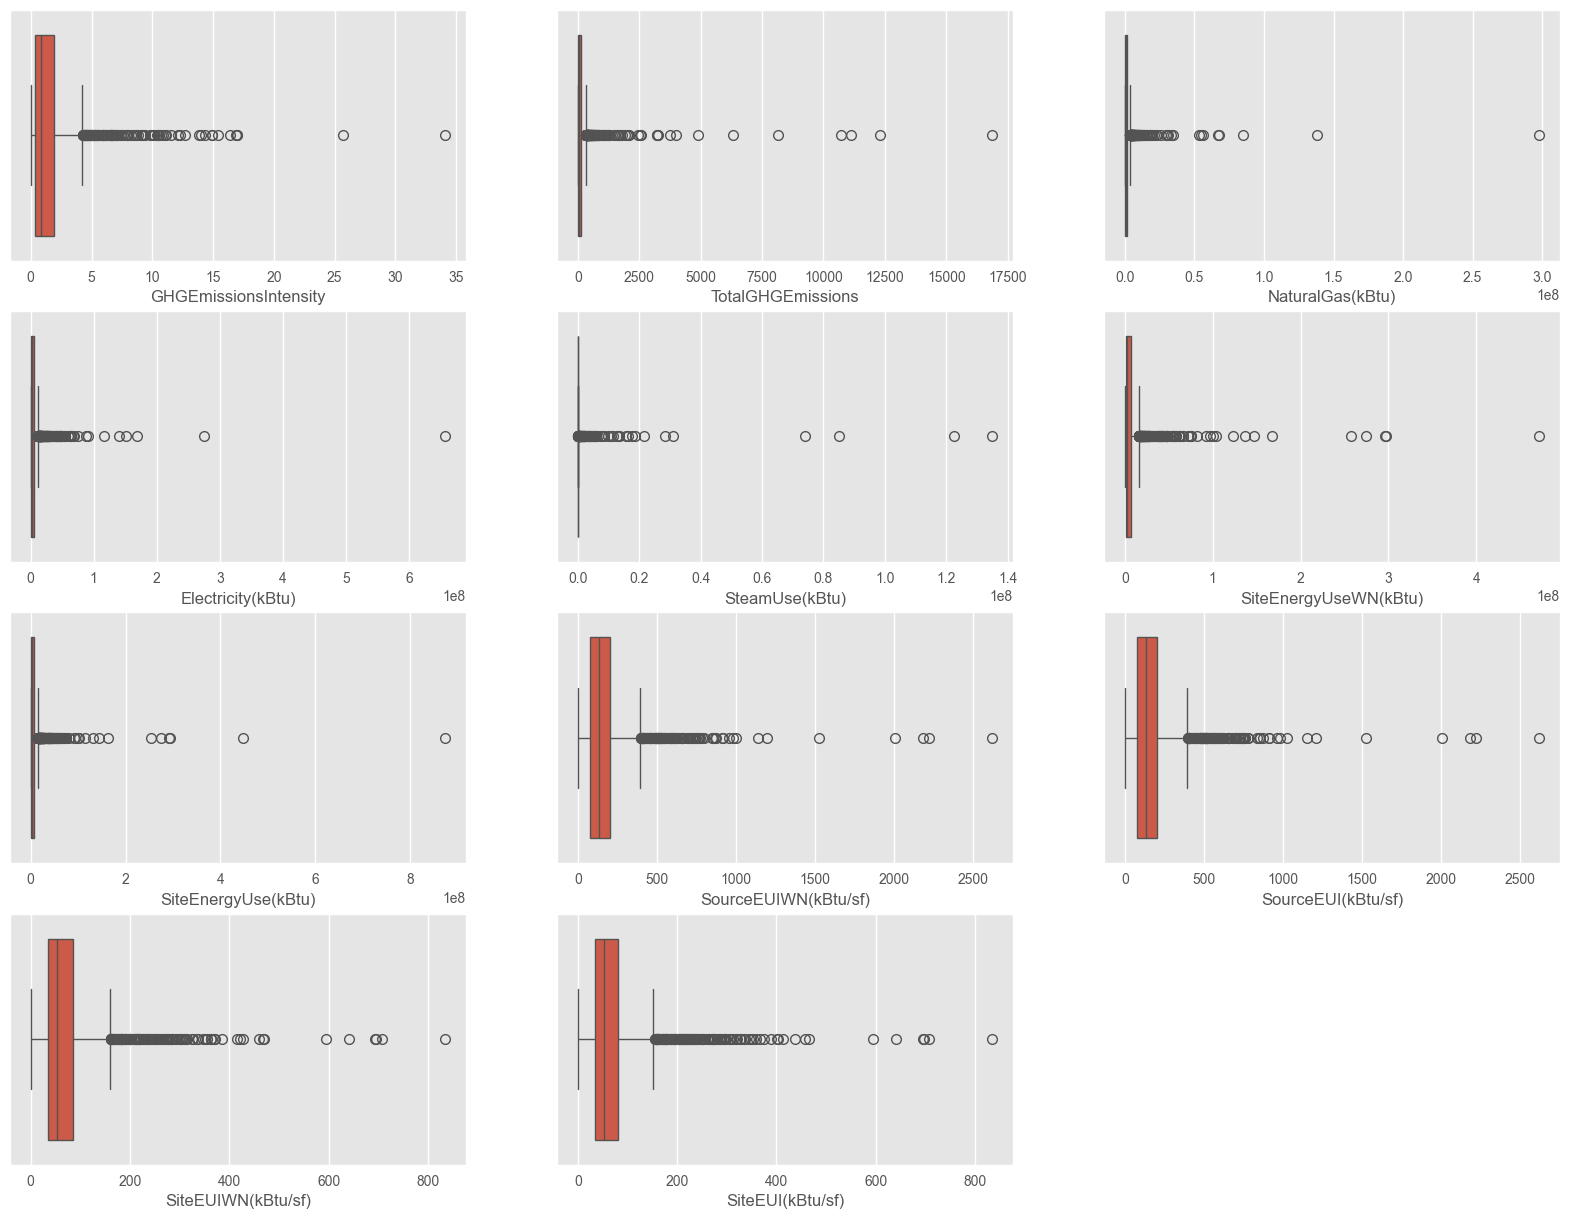

In [176]:
#Boites à moustaches

fig = plt.figure(1, figsize=(20, 15))
for i,label in enumerate(energy) :
    plt.subplot(4, 3, i + 1)
    sns.boxplot(fil_data[label], orient="h")
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_4464\3283003617.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fil_data[label].apply(lambda x : np.log(1 + x)), bins=int(1 + np.log2(len(fil_data))))
C:\Users\HP\AppData\Local\Temp\ipykernel_4464\3283003617.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.

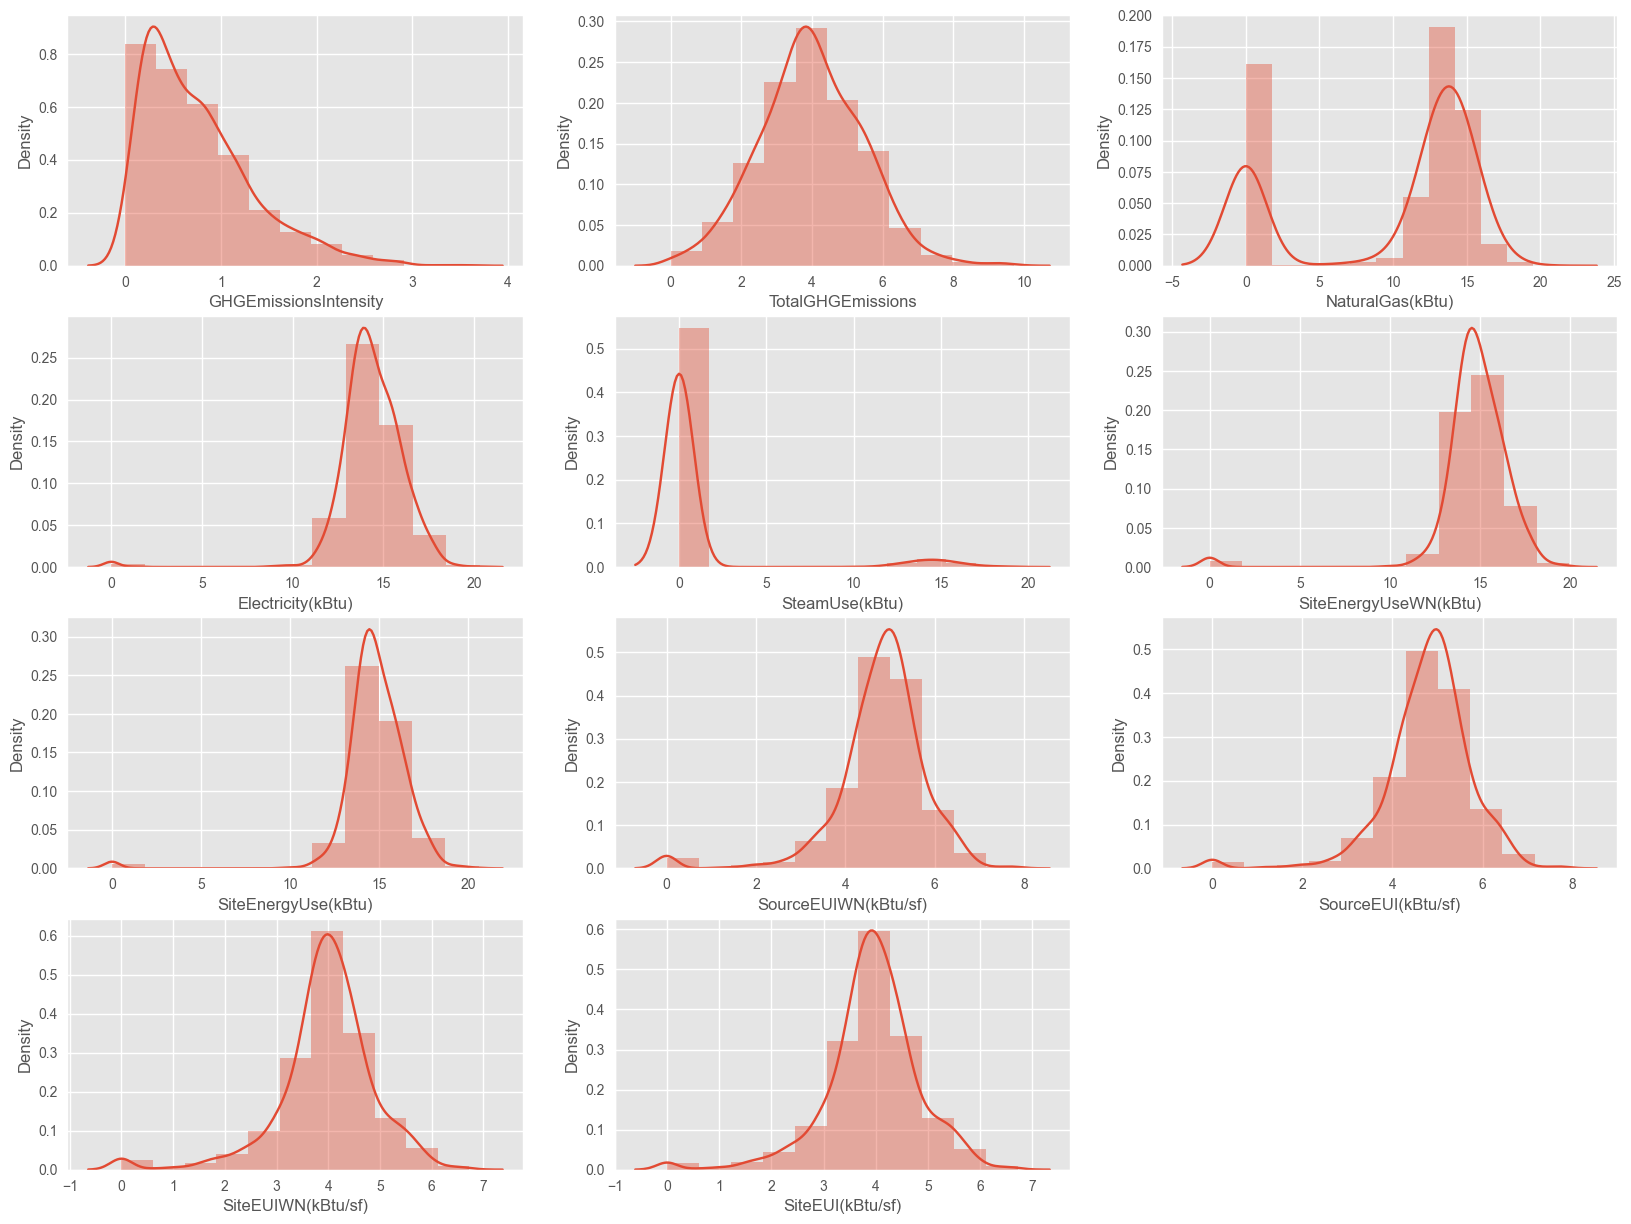

In [177]:
# Transformation au log

plt.style.use('ggplot')
fig = plt.figure(1, figsize=(20, 15))
for i, label in enumerate(energy) :
    plt.subplot(4, 3, i + 1)
    sns.distplot(fil_data[label].apply(lambda x : np.log(1 + x)), bins=int(1 + np.log2(len(fil_data))))
plt.show()

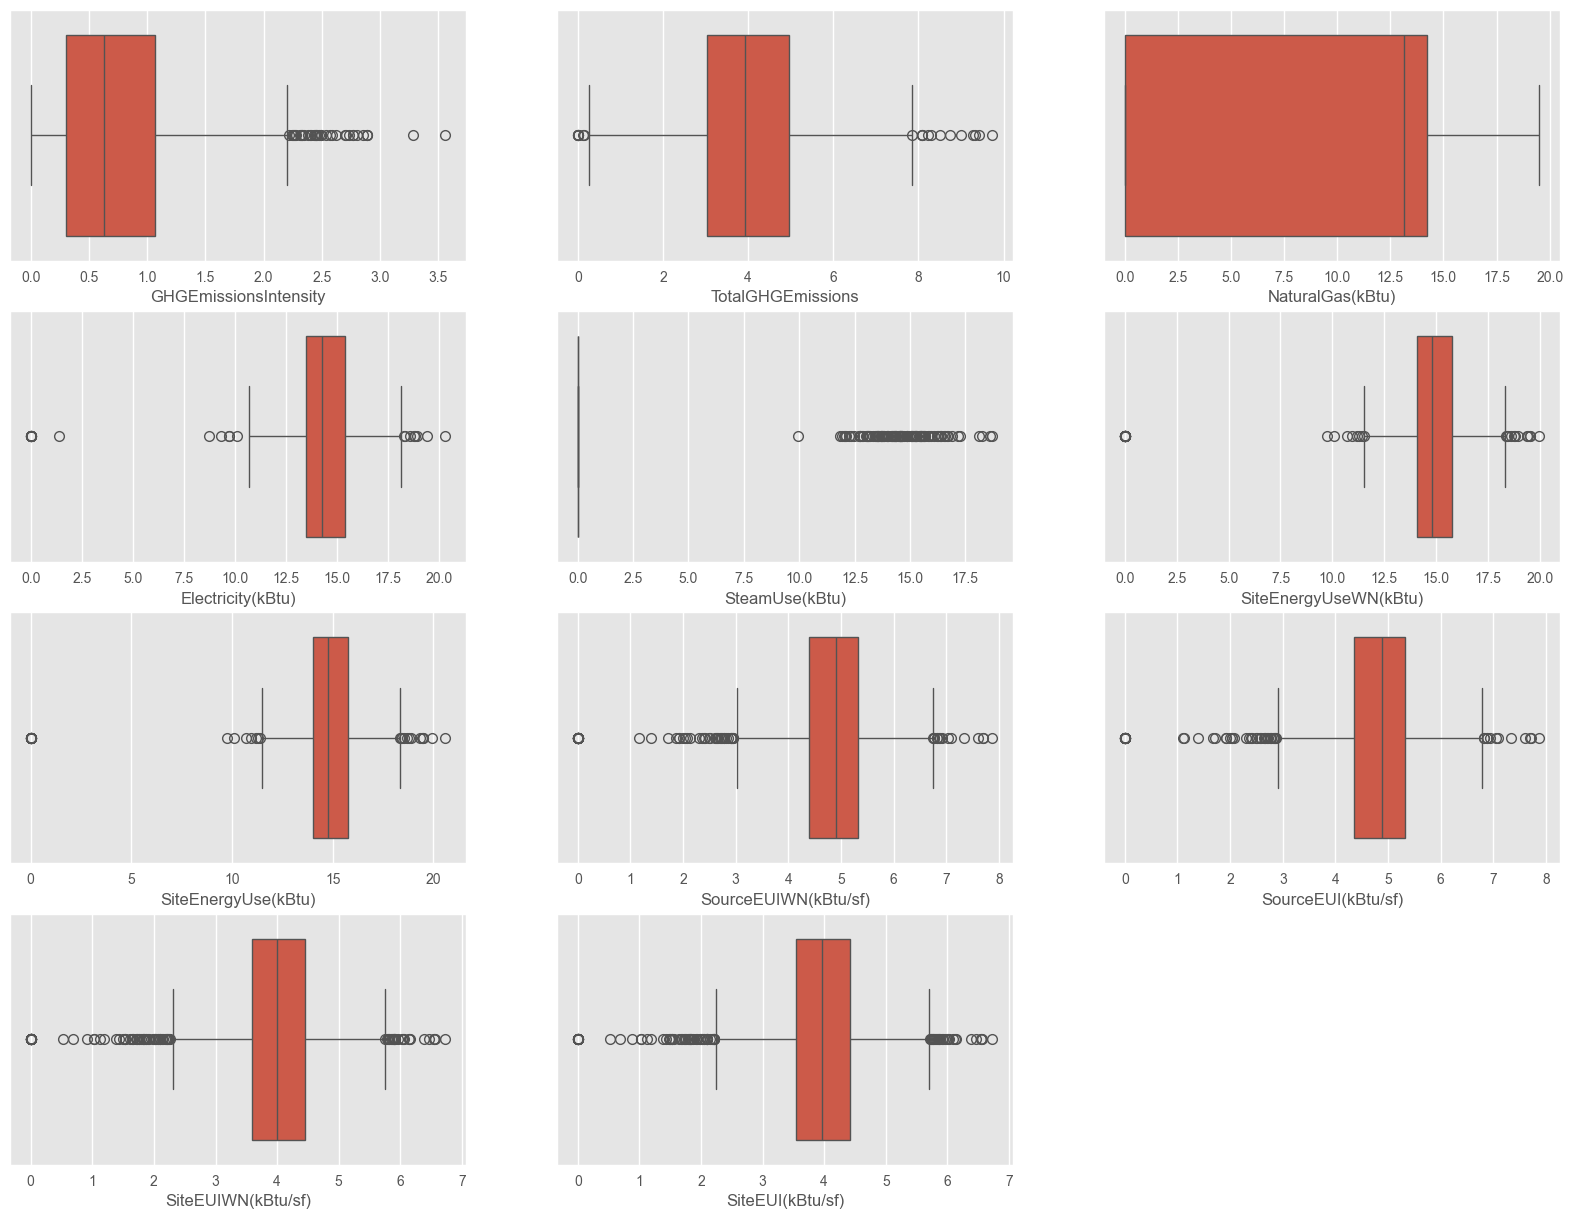

In [178]:
fig = plt.figure(1, figsize=(20, 15))
for i,label in enumerate(energy) :
    plt.subplot(4, 3, i + 1)
    sns.boxplot(fil_data[label].apply(lambda x : np.log(1 + x)), orient="h")
plt.show()

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Les boxplots montrent une variabilité importante et la présence d'outliers pour la majorité des variables énergétiques et des émissions. Cela souligne l'importance d'une analyse approfondie des valeurs aberrantes et d'une normalisation des données pour les étapes suivantes de modélisation.</div>

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Dans notre étude, nous traiterons les valeurs aberrantes à l’aide de la méthode de Coulomb et McKay. Ce choix s’explique par le fait que nos données présentent de grands ordres de grandeur, rendant d’autres méthodes, comme celle de l’intervalle interquartile, moins adaptées si elles sont appliquées directement sur les données brutes. L’un des principaux avantages de la méthode de Coulomb et McKay réside dans son utilisation des logarithmes, ce qui permet une meilleure gestion des données extrêmes.

Selon cette méthode, une valeur XjXj​ est considérée comme aberrante si :
ln⁡(Xj)>moy(ln⁡(X))+3×σ(ln⁡(X))
ln(Xj​)>moy(ln(X))+3×σ(ln(X))</div>

In [179]:
fil_data_2 = fil_data

In [180]:
for label in energy :
    std_label = fil_data_2[label].apply(lambda x : np.log(1 + x)).std()
    mean_label = fil_data_2[label].apply(lambda x : np.log(1 + x)).mean()
    fil_data_2 = fil_data_2[(fil_data[label].apply(lambda x : np.log(1 + x))< mean_label + 3*std_label)]

C:\Users\HP\AppData\Local\Temp\ipykernel_4464\3112893322.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fil_data_2 = fil_data_2[(fil_data[label].apply(lambda x : np.log(1 + x))< mean_label + 3*std_label)]
C:\Users\HP\AppData\Local\Temp\ipykernel_4464\3112893322.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fil_data_2 = fil_data_2[(fil_data[label].apply(lambda x : np.log(1 + x))< mean_label + 3*std_label)]
C:\Users\HP\AppData\Local\Temp\ipykernel_4464\3112893322.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fil_data_2 = fil_data_2[(fil_data[label].apply(lambda x : np.log(1 + x))< mean_label + 3*std_label)]
C:\Users\HP\AppData\Local\Temp\ipykernel_4464\3112893322.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fil_data_2 = fil_data_2[(fil_data[label].apply(lambda x : np.log(1 + x))< mean_label + 3*std_label)]
C:\Users\HP\AppData\Local\Temp\i

In [181]:
len(fil_data_2)- len(fil_data)

-135

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">La méthode de Coulomb et McKay a permis d’éliminer 135 observations.</div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:30px; text-align: center;">
     <strong>4. Analyse des variables catégorielles </strong>
</div> 

In [183]:
obj_columns

['BuildingType',
 'PrimaryPropertyType',
 'CouncilDistrictCode',
 'Neighborhood',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'DefaultData',
 'ComplianceStatus']

In [184]:
# Le nombre de modalité par variable

fil_data_2[obj_columns].apply(lambda col: col.nunique())

BuildingType                      5
PrimaryPropertyType              22
CouncilDistrictCode               7
Neighborhood                     19
ListOfAllPropertyUseTypes       337
LargestPropertyUseType           56
SecondLargestPropertyUseType     45
ThirdLargestPropertyUseType      39
DefaultData                       2
ComplianceStatus                  4
dtype: int64

In [185]:
# Transformons les modalités des variables catégorielles en majuscule pour éviter un double compte
for cat in fil_data_2[obj_columns]:
    fil_data_2[cat] = fil_data_2[cat].apply(lambda x: str(x).upper())
fil_data_2[obj_columns]

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,DefaultData,ComplianceStatus
1,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,"HOTEL, PARKING, RESTAURANT",HOTEL,PARKING,RESTAURANT,FALSE,COMPLIANT
4,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,"HOTEL, PARKING, SWIMMING POOL",HOTEL,PARKING,SWIMMING POOL,FALSE,COMPLIANT
5,NONRESIDENTIAL COS,OTHER,7,DOWNTOWN,POLICE STATION,POLICE STATION,NON CONCERNÉ,NON CONCERNÉ,FALSE,COMPLIANT
6,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,HOTEL,HOTEL,NON CONCERNÉ,NON CONCERNÉ,FALSE,COMPLIANT
8,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,HOTEL,HOTEL,NON CONCERNÉ,NON CONCERNÉ,FALSE,COMPLIANT
...,...,...,...,...,...,...,...,...,...,...
3370,NONRESIDENTIAL COS,OTHER,1,DELRIDGE NEIGHBORHOODS,OTHER - RECREATION,OTHER - RECREATION,NON CONCERNÉ,NON CONCERNÉ,FALSE,COMPLIANT
3371,NONRESIDENTIAL COS,OFFICE,2,GREATER DUWAMISH,OFFICE,OFFICE,NON CONCERNÉ,NON CONCERNÉ,TRUE,ERROR - CORRECT DEFAULT DATA
3372,NONRESIDENTIAL COS,OTHER,2,DOWNTOWN,OTHER - RECREATION,OTHER - RECREATION,NON CONCERNÉ,NON CONCERNÉ,FALSE,COMPLIANT
3374,NONRESIDENTIAL COS,MIXED USE PROPERTY,1,GREATER DUWAMISH,"FITNESS CENTER/HEALTH CLUB/GYM, FOOD SERVICE, ...",OTHER - RECREATION,FITNESS CENTER/HEALTH CLUB/GYM,PRE-SCHOOL/DAYCARE,FALSE,COMPLIANT


In [186]:
# Redeterminons le nombre de modalités par variables
fil_data_2[obj_columns].apply(lambda col: col.nunique())

BuildingType                      5
PrimaryPropertyType              22
CouncilDistrictCode               7
Neighborhood                     14
ListOfAllPropertyUseTypes       337
LargestPropertyUseType           56
SecondLargestPropertyUseType     45
ThirdLargestPropertyUseType      39
DefaultData                       2
ComplianceStatus                  4
dtype: int64

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Nous observons que le nombre de modalités de la variable Neighborhood a diminué. Concentrons-nous sur ses modalités pour déterminer si un recodage est nécessaire.</div>

In [187]:
fil_data_2['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'CENTRAL', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'SOUTHWEST', 'DELRIDGE',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">On peut remarquer que DELRIDGE NEIGHBORHOODS et DELRIDGE correspondent à la même modalité. Dans la suite, on remplace tous les DELRIDGE NEIGHBORHOODS par DELRIDGE </div>

In [188]:
fil_data_2['Neighborhood'] = fil_data_2['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')
fil_data_2['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'CENTRAL', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'SOUTHWEST', 'DELRIDGE'], dtype=object)

In [189]:
fil_data_2['PrimaryPropertyType'].unique()

array(['HOTEL', 'OTHER', 'K-12 SCHOOL', 'UNIVERSITY',
       'SMALL- AND MID-SIZED OFFICE', 'SELF-STORAGE FACILITY',
       'WAREHOUSE', 'LARGE OFFICE', 'SENIOR CARE COMMUNITY',
       'MEDICAL OFFICE', 'RETAIL STORE', 'HOSPITAL', 'RESIDENCE HALL',
       'DISTRIBUTION CENTER', 'MIXED USE PROPERTY', 'WORSHIP FACILITY',
       'SUPERMARKET / GROCERY STORE', 'LABORATORY',
       'REFRIGERATED WAREHOUSE', 'LOW-RISE MULTIFAMILY', 'RESTAURANT',
       'OFFICE'], dtype=object)

In [190]:
fil_data_2['LargestPropertyUseType'].unique()

array(['HOTEL', 'POLICE STATION', 'COURTHOUSE', 'OTHER', 'K-12 SCHOOL',
       'COLLEGE/UNIVERSITY', 'AUTOMOBILE DEALERSHIP', 'OFFICE',
       'SELF-STORAGE FACILITY', 'NON-REFRIGERATED WAREHOUSE',
       'OTHER - MALL', 'SENIOR CARE COMMUNITY', 'MEDICAL OFFICE',
       'RETAIL STORE', 'HOSPITAL (GENERAL MEDICAL & SURGICAL)', 'MUSEUM',
       'REPAIR SERVICES (VEHICLE, SHOE, LOCKSMITH, ETC)',
       'OTHER - LODGING/RESIDENTIAL', 'RESIDENCE HALL/DORMITORY',
       'OTHER/SPECIALTY HOSPITAL', 'FINANCIAL OFFICE',
       'OTHER - ENTERTAINMENT/PUBLIC ASSEMBLY', 'DISTRIBUTION CENTER',
       'PARKING', 'MULTIFAMILY HOUSING', 'WORSHIP FACILITY', 'RESTAURANT',
       'LABORATORY', 'SUPERMARKET/GROCERY STORE', 'CONVENTION CENTER',
       'OTHER - SERVICES', 'STRIP MALL', 'WHOLESALE CLUB/SUPERCENTER',
       'REFRIGERATED WAREHOUSE', 'MANUFACTURING/INDUSTRIAL PLANT',
       'OTHER - RECREATION', 'LIFESTYLE CENTER',
       'OTHER - PUBLIC SERVICES', 'DATA CENTER', 'SOCIAL/MEETING HALL',
       

In [191]:
fil_data_2['ListOfAllPropertyUseTypes'].unique()

array(['HOTEL, PARKING, RESTAURANT', 'HOTEL, PARKING, SWIMMING POOL',
       'POLICE STATION', 'HOTEL', 'HOTEL, PARKING', 'COURTHOUSE', 'OTHER',
       'K-12 SCHOOL', 'COLLEGE/UNIVERSITY', 'AUTOMOBILE DEALERSHIP',
       'HOTEL, PARKING, RETAIL STORE, SWIMMING POOL',
       'K-12 SCHOOL, MULTIFAMILY HOUSING, OFFICE, OTHER - ENTERTAINMENT/PUBLIC ASSEMBLY',
       'SELF-STORAGE FACILITY',
       'NON-REFRIGERATED WAREHOUSE, OFFICE, REFRIGERATED WAREHOUSE',
       'NON-REFRIGERATED WAREHOUSE, OFFICE', 'OFFICE, OTHER - EDUCATION',
       'OFFICE, SELF-STORAGE FACILITY, VOCATIONAL SCHOOL',
       'DATA CENTER, OFFICE, RETAIL STORE',
       'OTHER - MALL, PERSONAL SERVICES (HEALTH/BEAUTY, DRY CLEANING, ETC)',
       'OFFICE, RETAIL STORE', 'HOTEL, PARKING, RESTAURANT, RETAIL STORE',
       'HOTEL, OTHER - ENTERTAINMENT/PUBLIC ASSEMBLY, RETAIL STORE',
       'OFFICE', 'PARKING, SENIOR CARE COMMUNITY',
       'SENIOR CARE COMMUNITY', 'MEDICAL OFFICE', 'RETAIL STORE',
       'OFFICE, OTHER, PAR

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">La variable ListOfAllPropertyUseTypes contient des modalités sous forme de listes. La conserver ne serait pas pertinente, d'autant plus que nous disposons déjà de l'information relative à l'usage principal du bâtiment. Une alternative pour ne pas perdre complètement cette information serait de créer une nouvelle variable NumberOfPropertyUseTypes, qui représenterait le nombre de types d'usage différents pour chaque bâtiment.</div>

In [192]:
def compter_elements_uniques(liste):
    elements = [elem.strip() for elem in liste.split(',')]
    return len(set(elements))

# Créer une nouvelle colonne contenant le nombre d'éléments uniques dans chaque liste
fil_data_2['NumberOfPropertyUseTypes'] = fil_data_2['ListOfAllPropertyUseTypes'].apply(compter_elements_uniques)

In [193]:
fil_data_2['NumberOfPropertyUseTypes'].head()

1    3
4    3
5    1
6    1
8    1
Name: NumberOfPropertyUseTypes, dtype: int64

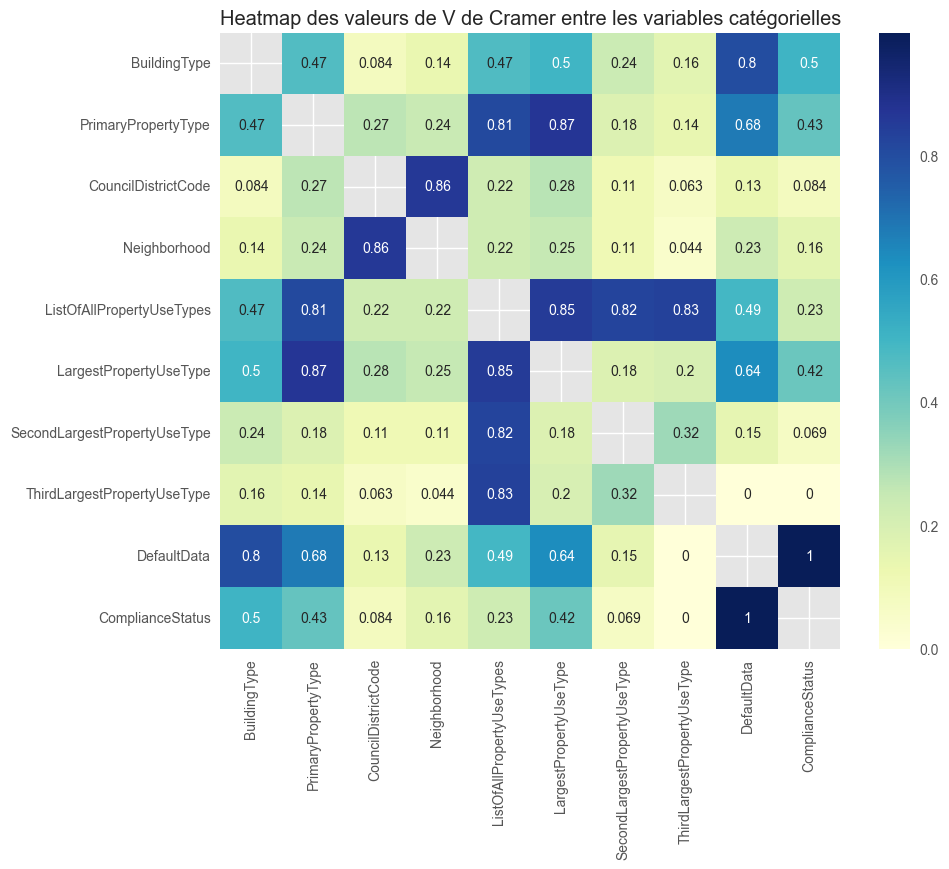

In [194]:
# Sélectionnez uniquement les colonnes catégorielles
data_cat = fil_data_2.select_dtypes(include=['object', 'category'])

# Créez une fonction pour calculer le V de Cramer
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)  * 2) / (n - 1)
    kcorr = k - ((k - 1) * 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Créez un DataFrame pour stocker les résultats du V de Cramer
cramers_v_results = pd.DataFrame(index=data_cat.columns, columns=data_cat.columns)

# Calculer le V de Cramer pour chaque paire de variables catégorielles
for col1 in data_cat.columns:
    for col2 in data_cat.columns:
        if col1 != col2:
            v_cramer = cramers_v(data_cat[col1], data_cat[col2])
            cramers_v_results.loc[col1, col2] = v_cramer

# Convertir les valeurs de V de Cramer en nombres flottants
cramers_v_results = cramers_v_results.astype(float)

# Créer un heatmap des valeurs de V de Cramer
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_results, annot=True, cmap="YlGnBu")
plt.title("Heatmap des valeurs de V de Cramer entre les variables catégorielles")
plt.show()

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">A l'aide de la statistique de <b>V de Cramer</b> nous pouvons distinguer : </p>

a. Les variables avec une forte association :</p>

<b>PrimaryPropertyType</b> et <b>LargestPropertyUseType</b> : V=0.87 </p>
Forte corrélation, ce qui est logique puisque le type d'utilisation principale de la propriété est souvent lié à son type de bâtiment.</p>
<b>ListOfAllPropertyUseTypes</b> et <b>LargestPropertyUseType</b> : V=0.85</p>
Ces deux variables sont également fortement associées, car elles décrivent en partie les mêmes informations.</p>
<b>BuildingType</b> et <b>DefaultData</b> : V=0.8</p>
Une forte association existe entre ces deux variables, ce qui peut suggérer que certaines catégories de bâtiments influencent la disponibilité ou la qualité des données.</p>

b. Les variables avec une faible association :</p>

<b>CouncilDistrictCode</b> et <b>ThirdLargestPropertyUseType</b> : V=0.044</p>
<b>Neighborhood</b> et <b>ThirdLargestPropertyUseType</b> : V=0.044</p>
Ces faibles valeurs indiquent une très faible relation entre ces variables.</p>

c. Les autres associations notables :</p>

<b>BuildingType</b> et <b>PrimaryPropertyType</b> : V=0.47</p>
Association modérée, suggérant une certaine dépendance entre le type de bâtiment et le type de propriété principale.</p>
<b>DefaultData</b> et <b>PrimaryPropertyType</b> : V=0.68</p>
Une relation forte existe, indiquant que certaines propriétés principales peuvent avoir un impact sur les données manquantes ou par défaut.</p>
La heatmap montre des associations fortes entre certaines variables catégorielles (notamment autour des types d'utilisation des bâtiments) et des associations faibles pour d'autres. Une analyse plus approfondie pourrait aider à réduire la redondance et améliorer l'efficacité des modèles en se concentrant sur les variables les plus pertinentes.</div>

In [195]:
fil_data_2['PrimaryPropertyType'].unique()

array(['HOTEL', 'OTHER', 'K-12 SCHOOL', 'UNIVERSITY',
       'SMALL- AND MID-SIZED OFFICE', 'SELF-STORAGE FACILITY',
       'WAREHOUSE', 'LARGE OFFICE', 'SENIOR CARE COMMUNITY',
       'MEDICAL OFFICE', 'RETAIL STORE', 'HOSPITAL', 'RESIDENCE HALL',
       'DISTRIBUTION CENTER', 'MIXED USE PROPERTY', 'WORSHIP FACILITY',
       'SUPERMARKET / GROCERY STORE', 'LABORATORY',
       'REFRIGERATED WAREHOUSE', 'LOW-RISE MULTIFAMILY', 'RESTAURANT',
       'OFFICE'], dtype=object)

In [196]:
fil_data_2.loc[fil_data_2['PrimaryPropertyType'] == 'LOW-RISE MULTIFAMILY', 'ListOfAllPropertyUseTypes']

644                                   MULTIFAMILY HOUSING
1300    BAR/NIGHTCLUB, FOOD SALES, MULTIFAMILY HOUSING...
2450                   BAR/NIGHTCLUB, MULTIFAMILY HOUSING
Name: ListOfAllPropertyUseTypes, dtype: object

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Nous constatons que ces bâtiments ont 'MULTIFAMILY HOUSING' parmi leurs usages, ainsi que des usages à caractère non résidentiel, à l'exception du premier, qui est entièrement résidentiel. Pour cette raison, nous allons l'écarter de l'analyse.</div>

In [197]:
fil_data_2 = fil_data_2[fil_data_2['ListOfAllPropertyUseTypes'] != 'MULTIFAMILY HOUSING']

In [198]:
# Nouvelles classes en anglais et en majuscules
new_classes = {
    'EDUCATION': ['K-12 SCHOOL', 'UNIVERSITY'],
    'HEALTH AND MEDICAL': ['SENIOR CARE COMMUNITY', 'HOSPITAL', 'MEDICAL OFFICE', 'LABORATORY'],
    'OFFICE AND BUSINESS': ['OFFICE', 'LARGE OFFICE', 'SMALL- AND MID-SIZED OFFICE'],
    'STORAGE': ['SELF-STORAGE FACILITY', 'WAREHOUSE', 'REFRIGERATED WAREHOUSE', 'DISTRIBUTION CENTER'],
    'RETAIL AND PERSONAL SERVICES': ['RETAIL STORE'],
    'HOTEL': ['HOTEL'],
    'RESIDENTIAL AND HOUSING': ['LOW-RISE MULTIFAMILY', 'RESIDENCE HALL'],
    'FOOD AND BEVERAGE': ['RESTAURANT', 'SUPERMARKET / GROCERY STORE'],
    'MIXED USE': ['MIXED USE PROPERTY'],
    'OTHER SERVICES AND FACILITIES': ['OTHER', 'WORSHIP FACILITY']
}

# Fonction pour mapper les classes
def map_class(category):
    for key, values in new_classes.items():
        if category in values:
            return key
    return 'UNDEFINED'

# Création de la PrimaryProperty en fonction de la PrimaryPropertyType
fil_data_2['PrimaryProperty'] = fil_data_2['PrimaryPropertyType'].apply(map_class)

In [199]:
fil_data_2['PrimaryProperty'].unique()

array(['HOTEL', 'OTHER SERVICES AND FACILITIES', 'EDUCATION',
       'OFFICE AND BUSINESS', 'STORAGE', 'HEALTH AND MEDICAL',
       'RETAIL AND PERSONAL SERVICES', 'RESIDENTIAL AND HOUSING',
       'MIXED USE', 'FOOD AND BEVERAGE'], dtype=object)

In [200]:
fil_data_2['SecondLargestPropertyUseType'].unique()

array(['PARKING', 'NON CONCERNÉ', 'K-12 SCHOOL', 'REFRIGERATED WAREHOUSE',
       'NON-REFRIGERATED WAREHOUSE', 'OTHER - EDUCATION',
       'VOCATIONAL SCHOOL', 'RETAIL STORE',
       'PERSONAL SERVICES (HEALTH/BEAUTY, DRY CLEANING, ETC)',
       'OTHER - ENTERTAINMENT/PUBLIC ASSEMBLY', 'RESTAURANT',
       'DATA CENTER', 'SWIMMING POOL', 'OFFICE', 'OTHER',
       'RESIDENCE HALL/DORMITORY', 'DISTRIBUTION CENTER',
       'SELF-STORAGE FACILITY', 'OTHER - SERVICES', 'LABORATORY',
       'MOVIE THEATER', 'SUPERMARKET/GROCERY STORE', 'MEDICAL OFFICE',
       'OTHER - RECREATION', 'CONVENIENCE STORE WITHOUT GAS STATION',
       'COLLEGE/UNIVERSITY', 'OTHER - RESTAURANT/BAR', 'ADULT EDUCATION',
       'ENCLOSED MALL', 'MULTIFAMILY HOUSING', 'PERFORMING ARTS',
       'REPAIR SERVICES (VEHICLE, SHOE, LOCKSMITH, ETC)',
       'MANUFACTURING/INDUSTRIAL PLANT', 'OTHER - LODGING/RESIDENTIAL',
       'BANK BRANCH', 'FITNESS CENTER/HEALTH CLUB/GYM', 'HOTEL',
       'WORSHIP FACILITY', 'FOOD SALES',

In [202]:
new_classes = {
    'EDUCATION': ['K-12 SCHOOL', 'VOCATIONAL SCHOOL', 'COLLEGE/UNIVERSITY', 'ADULT EDUCATION', 'OTHER - EDUCATION', 'PRE-SCHOOL/DAYCARE'],
    'RETAIL AND PERSONAL SERVICES': ['RETAIL STORE', 'PERSONAL SERVICES (HEALTH/BEAUTY, DRY CLEANING, ETC)', 'CONVENIENCE STORE WITHOUT GAS STATION'],
    'ENTERTAINMENT AND LEISURE': ['OTHER - ENTERTAINMENT/PUBLIC ASSEMBLY', 'MOVIE THEATER', 'SWIMMING POOL', 'PERFORMING ARTS', 'BAR/NIGHTCLUB', 'SOCIAL/MEETING HALL'],
    'FOOD AND BEVERAGE': ['RESTAURANT', 'SUPERMARKET/GROCERY STORE', 'FOOD SALES', 'FOOD SERVICE', 'OTHER - RESTAURANT/BAR'],
    'HEALTH AND MEDICAL': ['MEDICAL OFFICE', 'LABORATORY', 'FITNESS CENTER/HEALTH CLUB/GYM'],
    'OFFICE AND BUSINESS': ['OFFICE', 'DATA CENTER', 'MANUFACTURING/INDUSTRIAL PLANT', 'BANK BRANCH', 'REPAIR SERVICES (VEHICLE, SHOE, LOCKSMITH, ETC)'],
    'RESIDENTIAL AND HOUSING': ['RESIDENCE HALL/DORMITORY', 'MULTIFAMILY HOUSING', 'OTHER - LODGING/RESIDENTIAL'],
    'STORAGE': ['SELF-STORAGE FACILITY', 'REFRIGERATED WAREHOUSE', 'NON-REFRIGERATED WAREHOUSE', 'DISTRIBUTION CENTER'],
    'OTHER SERVICES AND FACILITIES': ['OTHER', 'OTHER - SERVICES', 'OTHER - RECREATION', 'OTHER - PUBLIC SERVICES', 'ENCLOSED MALL', 'AUTOMOBILE DEALERSHIP', 'WORSHIP FACILITY'],
    'NOT CONCERNED': ['NOT CONCERNED'],
    'HOTEL': ['HOTEL'],
    'PARKING': ['PARKING']
}

# Fonction pour mapper les classes
def map_class(category):
    for key, values in new_classes.items():
        if category in values:
            return key
    return 'UNDEFINED'

# Création de la SecondLargest en fonction de la SecondLargestPropertyUseType
fil_data_2['SecondLargest'] = fil_data_2['SecondLargestPropertyUseType'].apply(map_class)

In [203]:
fil_data_2['ThirdLargestPropertyUseType'].unique()

array(['RESTAURANT', 'SWIMMING POOL', 'NON CONCERNÉ', 'RETAIL STORE',
       'OTHER - ENTERTAINMENT/PUBLIC ASSEMBLY', 'OFFICE', 'DATA CENTER',
       'OTHER', 'DISTRIBUTION CENTER', 'FOOD SERVICE', 'OTHER - SERVICES',
       'MEDICAL OFFICE', 'PARKING', 'OTHER - UTILITY', 'K-12 SCHOOL',
       'FITNESS CENTER/HEALTH CLUB/GYM', 'PRE-SCHOOL/DAYCARE',
       'FINANCIAL OFFICE', 'OTHER - RESTAURANT/BAR',
       'MULTIFAMILY HOUSING', 'LABORATORY', 'BANK BRANCH',
       'NON-REFRIGERATED WAREHOUSE', 'HOTEL',
       'PERSONAL SERVICES (HEALTH/BEAUTY, DRY CLEANING, ETC)',
       'OTHER - RECREATION', 'SELF-STORAGE FACILITY',
       'OTHER - TECHNOLOGY/SCIENCE', 'REFRIGERATED WAREHOUSE',
       'BAR/NIGHTCLUB', 'SOCIAL/MEETING HALL',
       'MANUFACTURING/INDUSTRIAL PLANT', 'OTHER/SPECIALTY HOSPITAL',
       'FAST FOOD RESTAURANT', 'WORSHIP FACILITY',
       'SUPERMARKET/GROCERY STORE', 'OTHER - EDUCATION',
       'CONVENIENCE STORE WITHOUT GAS STATION', 'VOCATIONAL SCHOOL'],
      dtype=objec

In [204]:
# Nouvelles classes en anglais et en majuscules
new_classes = {
    'EDUCATION': ['K-12 SCHOOL', 'VOCATIONAL SCHOOL', 'COLLEGE/UNIVERSITY', 'ADULT EDUCATION', 'OTHER - EDUCATION', 'PRE-SCHOOL/DAYCARE'],
    'RETAIL AND PERSONAL SERVICES': ['RETAIL STORE', 'PERSONAL SERVICES (HEALTH/BEAUTY, DRY CLEANING, ETC)', 'CONVENIENCE STORE WITHOUT GAS STATION'],
    'ENTERTAINMENT AND LEISURE': ['SWIMMING POOL', 'OTHER - ENTERTAINMENT/PUBLIC ASSEMBLY', 'SOCIAL/MEETING HALL', 'BAR/NIGHTCLUB'],
    'FOOD AND BEVERAGE': ['RESTAURANT', 'FAST FOOD RESTAURANT', 'FOOD SERVICE', 'SUPERMARKET/GROCERY STORE'],
    'HEALTH AND MEDICAL': ['MEDICAL OFFICE', 'OTHER/SPECIALTY HOSPITAL', 'LABORATORY', 'FITNESS CENTER/HEALTH CLUB/GYM'],
    'OFFICE AND BUSINESS': ['OFFICE', 'DATA CENTER', 'FINANCIAL OFFICE', 'BANK BRANCH', 'MANUFACTURING/INDUSTRIAL PLANT'],
    'RESIDENTIAL AND HOUSING': ['MULTIFAMILY HOUSING'],
    'STORAGE': ['REFRIGERATED WAREHOUSE', 'NON-REFRIGERATED WAREHOUSE', 'DISTRIBUTION CENTER', 'SELF-STORAGE FACILITY'],
    'OTHER SERVICES AND FACILITIES': ['OTHER - SERVICES', 'OTHER - UTILITY', 'WORSHIP FACILITY', 'OTHER - RECREATION', 'OTHER - TECHNOLOGY/SCIENCE', 'OTHER', 'OTHER - RESTAURANT/BAR'],
    'HOTEL': ['HOTEL'],
    'PARKING': ['PARKING'],
    'NOT CONCERNED': ['NOT CONCERNED']
}

# Fonction pour mapper les classes
def map_class(category):
    for key, values in new_classes.items():
        if category in values:
            return key
    return 'UNDEFINED'

# Création de la ThirdLargest en fonction de la ThirdLargestPropertyUseType
fil_data_2['ThirdLargest'] = fil_data_2['ThirdLargestPropertyUseType'].apply(map_class)

In [205]:
fil_data_2['ThirdLargest'].unique()

array(['FOOD AND BEVERAGE', 'ENTERTAINMENT AND LEISURE', 'UNDEFINED',
       'RETAIL AND PERSONAL SERVICES', 'OFFICE AND BUSINESS',
       'OTHER SERVICES AND FACILITIES', 'STORAGE', 'HEALTH AND MEDICAL',
       'PARKING', 'EDUCATION', 'RESIDENTIAL AND HOUSING', 'HOTEL'],
      dtype=object)

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:30px; text-align: center;">
     <strong>Description de la variable SiteEnergyUse(kBtu) </strong>
</div> 
 

In [206]:
# Min Max de SiteEnergyUse(kBtu)
min_site_energy_use = fil_data_2['SiteEnergyUse(kBtu)'].min()
max_site_energy_use = fil_data_2['SiteEnergyUse(kBtu)'].max()

print("Le minimum en consommation de SiteEnergyUse(kBtu) est :", min_site_energy_use)
print("le maximum en consommation de SiteEnergyUse(kBtu) est :", max_site_energy_use)

Le minimum en consommation de SiteEnergyUse(kBtu) est : 0.0
le maximum en consommation de SiteEnergyUse(kBtu) est : 274682208.0


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">La consommation minimale est de 0. Ce qui nous semble irréaliste. Vérifions combien de batiments sont dans le cas. </div>

In [207]:
fil_data_2[fil_data_2['SiteEnergyUse(kBtu)']==0.0].shape
fil_data_2.loc[fil_data_2['SiteEnergyUse(kBtu)'] == 0.0, ['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)']]

,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu)
28,0.0,0.0,0.0
31,1496816.0,0.0,0.0
62,600813.0,0.0,0.0
81,1698176.0,0.0,0.0
85,2347138.0,0.0,0.0
95,2104286.0,0.0,0.0
133,0.0,4318917.0,0.0
139,0.0,3217877.0,0.0
152,0.0,0.0,0.0
304,0.0,0.0,0.0


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Nous observons que quelques-uns parmi les 16 bâtiments ayant une valeur nulle pour SiteEnergyUse présentent des valeurs non nulles pour au moins un type d'énergie consommée. La valeur nulle de SiteEnergyUse pour ces bâtiments est probablement due à une erreur. Pour ces cas, nous allons imputer SiteEnergyUse(kBtu) en calculant la somme de la consommation d'énergie pour chaque source.</div>

In [208]:
# Mise à jour de 'SiteEnergyUse(kBtu)' pour les lignes qui satisfont la condition
fil_data_2.loc[fil_data_2['SiteEnergyUse(kBtu)'] == 0.0, 'SiteEnergyUse(kBtu)'] = fil_data_2.loc[fil_data_2['SiteEnergyUse(kBtu)'] == 0.0, ['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)']].sum(axis=1)

In [209]:
fil_data_2.loc[fil_data_2['SiteEnergyUse(kBtu)'] == 0.0, ['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)']]

,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu)
28,0.0,0.0,0.0
152,0.0,0.0,0.0
304,0.0,0.0,0.0
746,0.0,0.0,0.0
1361,0.0,0.0,0.0


In [210]:
print("Nous avons a présent ", fil_data_2.loc[fil_data_2['SiteEnergyUse(kBtu)'] == 0.0, ['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)']].shape[0], "batiments dont SiteEnergyUse est nulle")

Nous avons a présent  5 batiments dont SiteEnergyUse est nulle


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Pour ces 5 bâtiments, nous constatons que la consommation d'énergie pour chaque source est nulle. Ce type d'observation, ne présentant aucune consommation d'énergie, ne serait pas pertinent pour notre objectif de prédiction de la consommation énergétique des bâtiments. Il pourrait s'agir de bâtiments non exploités. Nous avons donc choisi de supprimer les observations concernées.</div>

In [211]:
fil_data_2 = fil_data_2[fil_data_2['SiteEnergyUse(kBtu)']!=0.0]

In [212]:
# Min Max de SiteEnergyUse(kBtu)
min_site_energy_use = fil_data_2['SiteEnergyUse(kBtu)'].min()
max_site_energy_use = fil_data_2['SiteEnergyUse(kBtu)'].max()

print("Le minimum en consommation de SiteEnergyUse(kBtu) est :", min_site_energy_use)
print("Le maximum en consommation de SiteEnergyUse(kBtu) est :", max_site_energy_use)

Le minimum en consommation de SiteEnergyUse(kBtu) est : 16808.90039
Le maximum en consommation de SiteEnergyUse(kBtu) est : 274682208.0


<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:30px; text-align: center;">
     <strong>Statistique descriptive sur Electricity(kBtu), NaturalGas(kBtu) et SteamUse(kBtu)</strong>
</div> 

In [213]:
# Part de l'electricité et du gaz naturel dans la consommation

consommation_totale = fil_data_2['SiteEnergyUse(kBtu)'].sum()

consommation_electricite = fil_data_2['Electricity(kBtu)'].sum()
consommation_gaz_naturel = fil_data_2['NaturalGas(kBtu)'].sum()
consommation_steam = fil_data_2['SteamUse(kBtu)'].sum()

pourcentage_electricite = (consommation_electricite / consommation_totale) * 100
pourcentage_gaz_naturel = (consommation_gaz_naturel / consommation_totale) * 100
pourcentage_steam = (consommation_steam / consommation_totale) * 100


print("La part en pourcentage de la consommation d'électricité dans la consommation totale est : {:.5f}".format(pourcentage_electricite))
print("La part en pourcentage de la consommation de gaz naturel dans la consommation totale est :{:.5f}".format(pourcentage_gaz_naturel))
print("La part en pourcentage d'utilisation de vapeur dans la consommation totale est :{:.5f}".format(pourcentage_steam))

La part en pourcentage de la consommation d'électricité dans la consommation totale est : 73.58757
La part en pourcentage de la consommation de gaz naturel dans la consommation totale est :25.70460
La part en pourcentage d'utilisation de vapeur dans la consommation totale est :0.00023


<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:30px; text-align: center;">
     <strong>Statistique descriptive sur le nombre d'année d'ancienneté des batiments</strong>
</div> 

In [214]:
fil_data_2['NombreAnnees'] = 2016 - fil_data_2['YearBuilt']
min_nombre_annee = fil_data_2['NombreAnnees'].min()
max_nombre_annee = fil_data_2['NombreAnnees'].max()

print("Le minimum de nombre d'année d'ancienneté des batiments est de :", min_nombre_annee, "an(s)")
print("le maximum de nombre d'année d'ancienneté des batiments est de :", max_nombre_annee, "an(s)") 

Le minimum de nombre d'année d'ancienneté des batiments est de : 1 an(s)
le maximum de nombre d'année d'ancienneté des batiments est de : 116 an(s)


<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:30px; text-align: center;">
    <strong>Visualisation des données</strong>
</div> 

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:25px; text-align: center;">
    <strong>1. Analyse de la liaison entre SiteEnergyUse et Electricity(kBtu), NaturalGas(kBtu) et SteamUse(kBtu)</strong>
</div> 

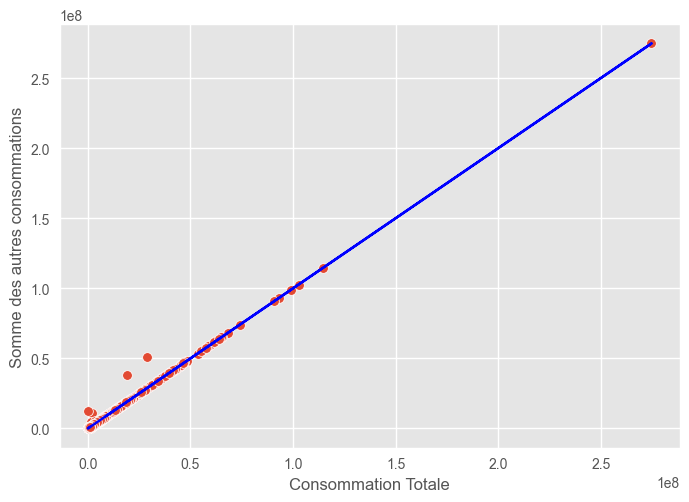

In [215]:
y = fil_data_2['SiteEnergyUse(kBtu)']
x = fil_data_2['Electricity(kBtu)'] + fil_data_2['NaturalGas(kBtu)']+ fil_data_2['SteamUse(kBtu)']

# Tracé
sns.scatterplot(x=x, y=y)
plt.plot(y, y, color='blue', linestyle='-')  # Tracé de la droite y=x en rouge en pointillés
plt.xlabel('Consommation Totale')
plt.ylabel('Somme des autres consommations')
plt.title('')
plt.show()

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Dans le graphique ci-dessus, la droite bleue représente la première bissectrice, tandis que les points illustrent la répartition de la somme des trois types d’énergies par rapport à la consommation totale. On observe clairement que la somme des trois énergies est presque égale à la consommation totale d’énergie, indiquant une corrélation linéaire forte avec cette dernière. Autrement dit, la connaissance de ces trois variables suffit déjà pour prédire la consommation totale. Par conséquent, pour améliorer les performances de notre modèle, nous pourrions envisager de les exclure.</div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:25px; text-align: center;">2.Liaison entre l'intensité d'émission et la consommation par surface
</div> 

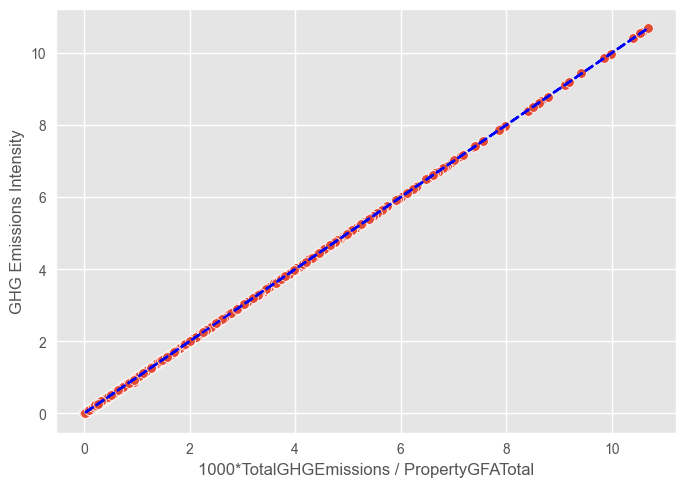

In [216]:
y = fil_data_2['GHGEmissionsIntensity']
x = 1000*fil_data_2['TotalGHGEmissions']/ fil_data_2['PropertyGFATotal']

# Tracé
sns.scatterplot(x=x, y=y)
plt.plot(y, y, color='blue', linestyle='--')  # Tracé de la droite y=x en rouge en pointillés
plt.xlabel('1000*TotalGHGEmissions / PropertyGFATotal')
plt.ylabel('GHG Emissions Intensity')
plt.title('')
plt.show()

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">On voit également de façon claire que la variable intensité d'émissions de GHG est fonction de la consommation par surface. Il en de même pour les variables (kBtu/sf) qui peuvent se déduire facilement. Ainsi nous pourront envisager de les enlèverons de notre modèle.  </div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:25px; text-align: center;">
    <strong>3. Croisement entre la variable SiteEnergyUse(kBtu) et la variable superficie des batiments</strong>
</div>  

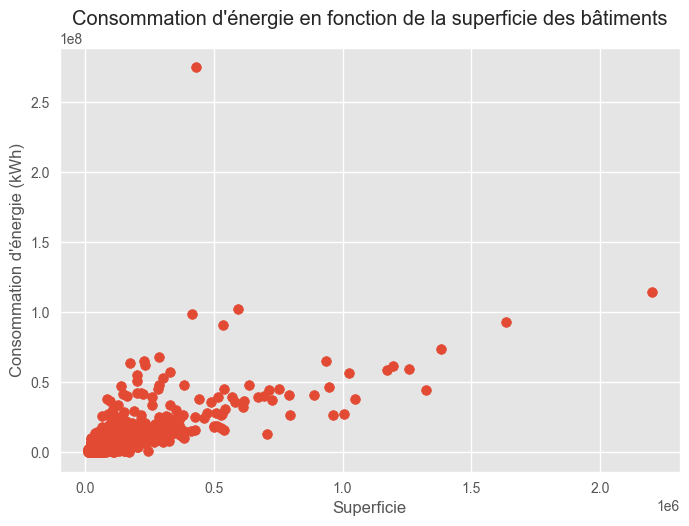

In [217]:
superficie = fil_data_2["PropertyGFABuilding(s)"]
consommation_energie = fil_data_2["SiteEnergyUse(kBtu)"]

# Crée un nuage de points
plt.scatter(superficie, consommation_energie)
plt.title("Consommation d'énergie en fonction de la superficie des bâtiments")
plt.xlabel("Superficie")
plt.ylabel("Consommation d'énergie (kWh)")

# Affiche le nuage de points
plt.show()

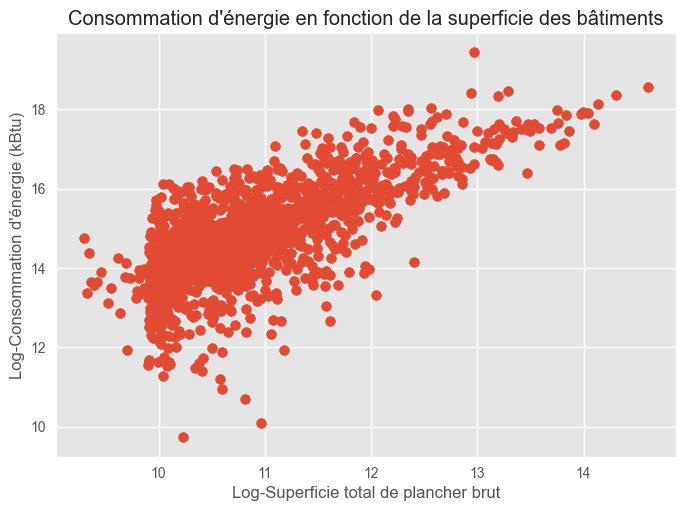

In [218]:
superficie = fil_data_2["PropertyGFABuilding(s)"]
consommation_energie = fil_data_2["SiteEnergyUse(kBtu)"]

# Calcul du logarithme de la consommation d'énergie
log_consommation_energie = np.log(consommation_energie)
# Crée un nuage de points
plt.scatter(np.log(superficie), log_consommation_energie)
plt.title("Consommation d'énergie en fonction de la superficie des bâtiments")
plt.xlabel("Log-Superficie total de plancher brut")
plt.ylabel("Log-Consommation d'énergie (kBtu)")

# Affiche le nuage de points
plt.show()

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">
Ce graphique montre une corrélation positive entre la consommation d'énergie et la superficie total des batiments.</div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:25px; text-align: center;">
    <strong>4. Croisement entre la variable SiteEnergyUse(kBtu) et la variable nombre d'étages </strong>
</div> 

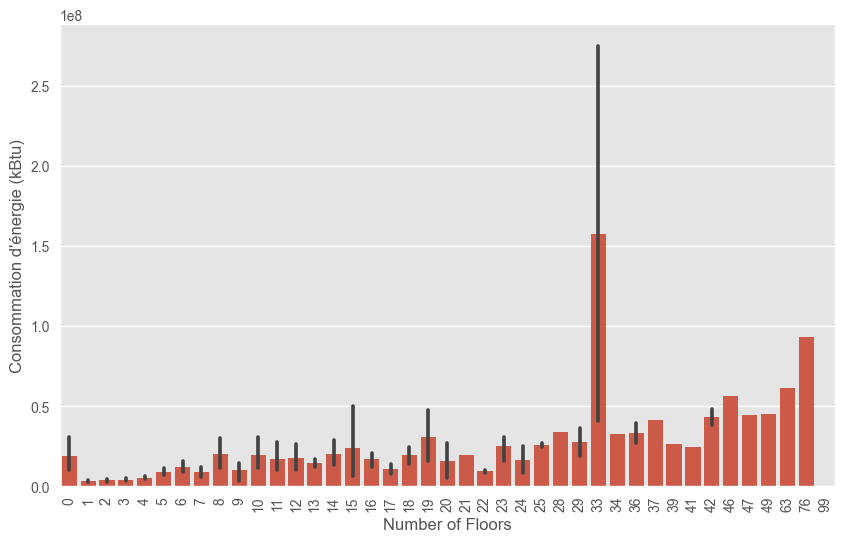

In [219]:
means_by_floor = fil_data_2.groupby('NumberofFloors')['SiteEnergyUse(kBtu)'].mean().reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(x=fil_data_2['NumberofFloors'], y=fil_data_2['SiteEnergyUse(kBtu)'], data=means_by_floor)
plt.xlabel('Number of Floors')
plt.ylabel('Consommation d\'énergie (kBtu)')
plt.xticks(rotation=90)
plt.show()


<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:25px; text-align: center;">
    <strong>5. Croisement entre nombre d'année d'ancienneté des batiments et SiteEnergyUse</strong>
</div>  

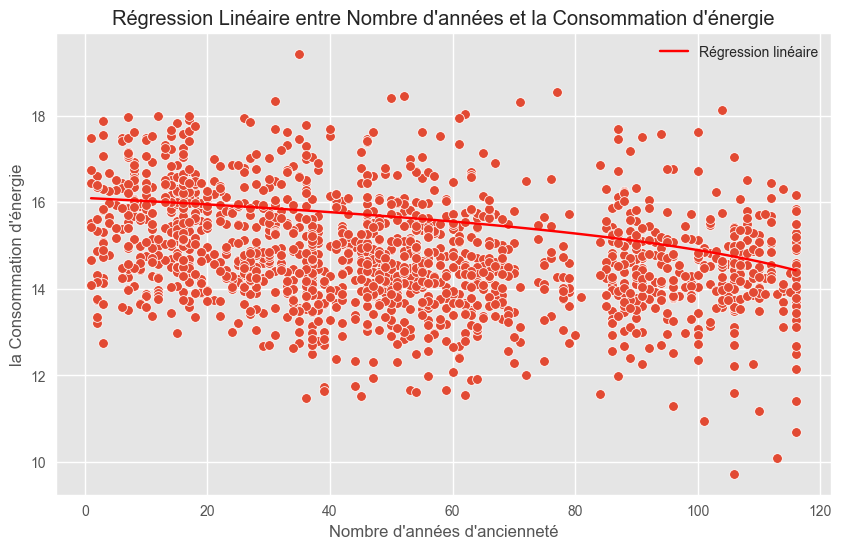

In [220]:
from sklearn.linear_model import LinearRegression

# Supprimer les lignes avec des valeurs manquantes pour éviter des problèmes de calcul
data_for_regression = fil_data_2[['NombreAnnees', 'SiteEnergyUse(kBtu)']].dropna()

# Régression linéaire
X = data_for_regression[['NombreAnnees']]
y = data_for_regression['SiteEnergyUse(kBtu)']

# Créer le modèle de régression linéaire
model = LinearRegression()

# Adapter le modèle aux données
model.fit(X, y)

# Prédictions
predictions = model.predict(X)

# Représentation graphique en nuage de points avec le logarithme de la consommation d'énergie
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(x='NombreAnnees', y=np.log1p(data_for_regression['SiteEnergyUse(kBtu)']), data=data_for_regression, ax=ax)
sns.lineplot(x=data_for_regression['NombreAnnees'], y=np.log1p(predictions), color='red', label='Régression linéaire', ax=ax)

ax.set(xlabel='Nombre d\'années d\'ancienneté', ylabel='la Consommation d\'énergie')
plt.title('Régression Linéaire entre Nombre d\'années et la Consommation d\'énergie')
plt.legend()
plt.show()

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Réalisons un test statistique pour examiner la relation entre le nombre d'années et la consommation d'énergie, afin d'obtenir plus d'informations sur leur lien.
Pour tester l'hypothèse selon laquelle le nombre d'années est lié à la quantité de consommation d'énergie, nous procéderons à une analyse de corrélation. Un test couramment utilisé pour évaluer la corrélation entre deux variables continues est le test de corrélation de Pearson.
L'hypothèse nulle H0​ stipule que les deux variables ne sont pas corrélées, tandis que l'hypothèse alternative H1​ indique qu'elles sont corrélées. </div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:25px; text-align: center;">
    <strong>Corrélation entre la variable SiteEnergyUse(kBtu) et la variable superficie des batiments</strong>
</div>   

In [221]:
from scipy.stats import pearsonr

# Supprimer les lignes avec des valeurs manquantes pour éviter des problèmes de calcul
data_for_correlation = fil_data_2[['NombreAnnees', 'SiteEnergyUse(kBtu)']].dropna()

# Effectuer le test de corrélation de Pearson
correlation_coefficient, p_value = pearsonr(data_for_correlation['NombreAnnees'], np.log1p(data_for_correlation['SiteEnergyUse(kBtu)']))

# Afficher le coefficient de corrélation et la valeur p
print("Valeur p:", p_value)
print("Coefficient de corrélation:", correlation_coefficient)

Valeur p: 4.077479621827629e-33
Coefficient de corrélation: -0.30051418409318176


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;"> Le test de Pearson nous indique une corrélation entre les deux variables; corrélation qui est faible d'après le coefficient de corrélation obtenu.   </div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:25px; text-align: center;">
    <strong> Matrice de correlation</strong>
</div> 

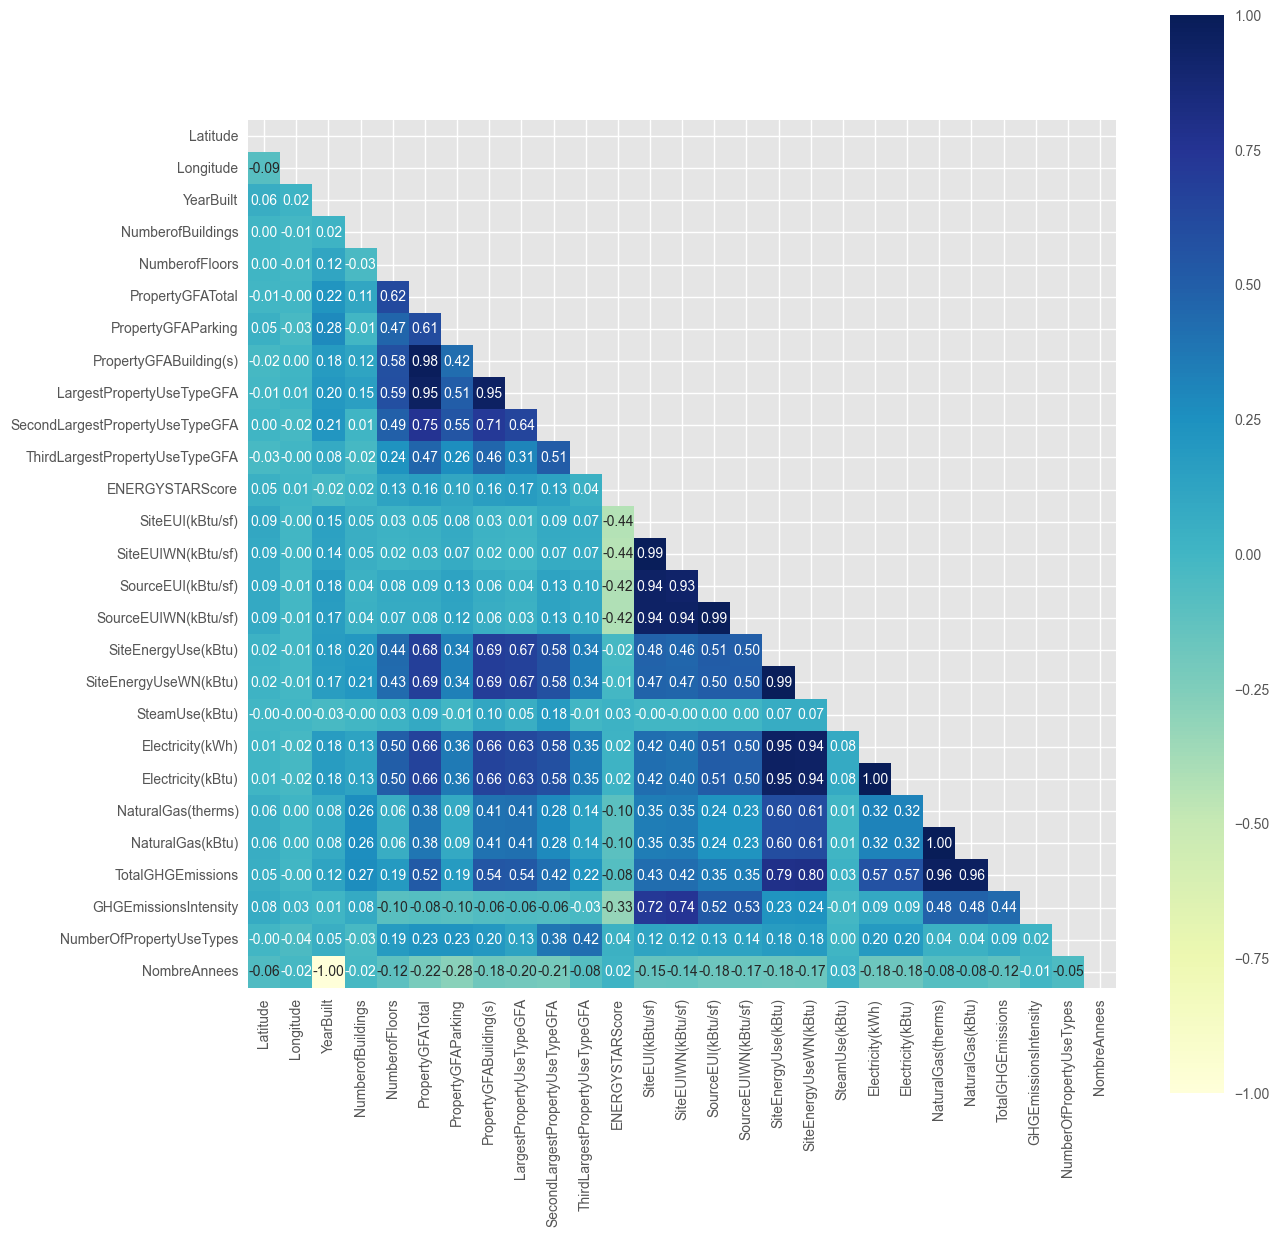

In [223]:
# correlation plot
plt.figure(figsize=(14, 14))
corr =fil_data_2.select_dtypes(include=[int, float]).corr(method="pearson")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, cmap="YlGnBu", annot=True, square=True,
            fmt='.2f',
            mask=mask,
            cbar=True, vmin=-1, vmax=1);

In [224]:
var = [
    'SiteEUI(kBtu/sf)', 
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'GHGEmissionsIntensity',
    'NaturalGas(kBtu)',
    'Electricity(kBtu)',
    'SteamUse(kBtu)',
    'Longitude',
    'Latitude',
    'PropertyGFATotal'
] + [
    'DefaultData', 
    'Electricity(kWh)',
    'NaturalGas(therms)',
    'ComplianceStatus',
    'ListOfAllPropertyUseTypes',
    'PrimaryPropertyType',
    'LargestPropertyUseType',
    'SecondLargestPropertyUseType',
    'ThirdLargestPropertyUseType',
    'SiteEnergyUseWN(kBtu)'
]
var
fil_data_2.drop(var,inplace = True, axis= 1)

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">La matrice de corrélation montre les relations suivantes :</p>
La variable <b>SiteEnergyUse(kBtu)</b> est fortement corrélée avec les variables <b>TotalGHGEmissions</b>, <b>Electricity(kBtu)</b> et <b>SiteEnergyUseWN(kBtu)</b>.</p>
La variable <b>TotalGHGEmissions</b> est fortement corrélée avec les variables <b>NaturalGas(kBtu)</b> et <b>SiteEnergyUseWN(kBtu)</b>.</p>
La variable <b>SourceEUIWN(kBtu/sf)</b> est fortement corrélée avec la variable <b>SourceEUI(kBtu/sf)</b>. </div>

In [225]:
fil_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1521 entries, 1 to 3375
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1521 non-null   object 
 1   CouncilDistrictCode              1521 non-null   object 
 2   Neighborhood                     1521 non-null   object 
 3   YearBuilt                        1521 non-null   int64  
 4   NumberofBuildings                1521 non-null   float64
 5   NumberofFloors                   1521 non-null   int64  
 6   PropertyGFAParking               1521 non-null   int64  
 7   PropertyGFABuilding(s)           1521 non-null   int64  
 8   LargestPropertyUseTypeGFA        1521 non-null   float64
 9   SecondLargestPropertyUseTypeGFA  1521 non-null   float64
 10  ThirdLargestPropertyUseTypeGFA   1521 non-null   float64
 11  ENERGYSTARScore                  1008 non-null   float64
 12  SiteEnergyUse(kBtu)      

In [226]:
fil_data_2.to_csv(Path(DATA, "2016_Building_Energy_2.csv"), index=False)

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:30px; sans-serif; text-align: center;">
    <strong>Deuxième Mission : Tester différents modèles de prédiction afin de répondre au mieux à la problématique.</strong>
</div>


In [227]:
data = pd.read_csv(Path(DATA, "2016_Building_Energy_2.csv"))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521 entries, 0 to 1520
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1521 non-null   object 
 1   CouncilDistrictCode              1521 non-null   int64  
 2   Neighborhood                     1521 non-null   object 
 3   YearBuilt                        1521 non-null   int64  
 4   NumberofBuildings                1521 non-null   float64
 5   NumberofFloors                   1521 non-null   int64  
 6   PropertyGFAParking               1521 non-null   int64  
 7   PropertyGFABuilding(s)           1521 non-null   int64  
 8   LargestPropertyUseTypeGFA        1521 non-null   float64
 9   SecondLargestPropertyUseTypeGFA  1521 non-null   float64
 10  ThirdLargestPropertyUseTypeGFA   1521 non-null   float64
 11  ENERGYSTARScore                  1008 non-null   float64
 12  SiteEnergyUse(kBtu) 

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>Choix de la variable à predire </strong>
</div>

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">L’objectif principal de notre projet est de prédire <b>la consommation énergétique</b> des bâtiments de la ville de Seattle. Notre base de données contient quatre variables fournissant des informations sur cette consommation :</p>

<b>SiteEnergyUseWN(kBtu)</b> : La consommation annuelle d’énergie de la propriété, toutes sources confondues, ajustée aux conditions météorologiques moyennes sur 30 ans.</p>

<b>SiteEnergyUse(kBtu)</b> : La consommation annuelle d’énergie de la propriété, toutes sources confondues.</p>

<b>SiteEUIWN(kBtu/sf)</b> : L’intensité de consommation énergétique normalisée selon les conditions météorologiques (WN), calculée en divisant la consommation énergétique ajustée par la superficie brute de la propriété (en pieds carrés). Cette intensité est exprimée en milliers de BTU par pied carré.</p>

<b>SiteEUI(kBtu/sf)</b> : L’intensité énergétique brute du site, mesurée en divisant la consommation annuelle d’énergie par la superficie brute de plancher. Cette mesure reflète la consommation sur site telle qu’indiquée sur les factures de services publics, exprimée en milliers de BTU par pied carré.</p>

Dans notre analyse, nous avons choisi de nous concentrer sur <b>SiteEnergyUse(kBtu)</b>, qui représente la consommation totale d’énergie du bâtiment, toutes sources confondues. Les variables exprimées en <b>(kBtu/sf)</b> sont des intensités énergétiques, qui dépendent directement de la consommation réelle d’énergie et ne constituent pas une mesure absolue. De plus, nous visons une estimation à court terme (sur une année), ce qui justifie notre décision de ne pas retenir <b>SiteEnergyUseWN(kBtu)</b>, laquelle fournit une consommation moyenne ajustée sur 30 ans.</div>

In [228]:
# Sélectionnez les colonnes catégorielles
df_cat = data.select_dtypes(include=['object'])

# Sélectionnez les colonnes numériques
df_num = data.select_dtypes(exclude=['object'])

# Concaténez les DataFrames dans le bon ordre
data = pd.concat([df_cat, df_num], axis=1)
data = data.iloc[:, data.columns != "ENERGYSTARScore"]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521 entries, 0 to 1520
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1521 non-null   object 
 1   Neighborhood                     1521 non-null   object 
 2   PrimaryProperty                  1521 non-null   object 
 3   SecondLargest                    1521 non-null   object 
 4   ThirdLargest                     1521 non-null   object 
 5   CouncilDistrictCode              1521 non-null   int64  
 6   YearBuilt                        1521 non-null   int64  
 7   NumberofBuildings                1521 non-null   float64
 8   NumberofFloors                   1521 non-null   int64  
 9   PropertyGFAParking               1521 non-null   int64  
 10  PropertyGFABuilding(s)           1521 non-null   int64  
 11  LargestPropertyUseTypeGFA        1521 non-null   float64
 12  SecondLargestPropert

In [229]:
X_index = data.columns != "SiteEnergyUse(kBtu)"  # Récupérer les colonnes différentes de "SiteEnergyUse(kBtu)"
y_index = data.columns == "SiteEnergyUse(kBtu)"  # Récupérer la colonne "SiteEnergyUse(kBtu)"

# Séparer les caractéristiques (X) et la cible (y) en utilisant iloc
X = data.iloc[:, X_index]
y = np.log1p(data.iloc[:, y_index])

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;"> Nous allons tester plusieurs modèles afin de sélectionner celui qui semble le plus performant et susceptible de fournir les meilleures prédictions. De plus, nous veillerons à optimiser les modèles afin d’éviter le surapprentissage ou le sous-apprentissage, en ajustant les paramètres adéquats pour chaque modèle.</p>

Pour la modélisation, nous séparons la variable cible en y et les variables explicatives en X. Ensuite, nous diviserons X et y en ensembles d'entraînement (X_train, y_train) et de test (X_test, y_test). Nous entraînerons notre modèle sur <b>X_train</b> et <b>y_train</b>, puis nous l'évaluerons sur <b>X_test</b> et <b>y_test</b>.</p>

Étant donné que notre objectif est de prédire la consommation d'énergie, nous nous trouvons face à un problème de régression. Nous allons donc tester plusieurs algorithmes de régression, en commençant par des modèles simples comme <b>LinearRegression</b>, <b>ElasticNet</b> et <b>RidgeRegression</b>, en raison de leur simplicité d'implémentation. Parallèlement, nous expérimenterons des modèles non linéaires comme <b>KNN</b>, qui est facile à comprendre, à implémenter, et qui s’ajuste bien aux nouvelles données. </div>

In [230]:
num_columns =  ['PropertyGFAParking',
  'PropertyGFABuilding(s)',
  'LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'ThirdLargestPropertyUseTypeGFA',
  'TotalGHGEmissions',
                'YearBuilt',
                'NumberofBuildings',
                'NumberofFloors',
                'NumberOfPropertyUseTypes',
                'NombreAnnees'
                           
]
obj_columns = list(data.select_dtypes(include=['object', 'bool']).columns)
obj_columns,num_columns

(['BuildingType',
  'Neighborhood',
  'PrimaryProperty',
  'SecondLargest',
  'ThirdLargest'],
 ['PropertyGFAParking',
  'PropertyGFABuilding(s)',
  'LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'ThirdLargestPropertyUseTypeGFA',
  'TotalGHGEmissions',
  'YearBuilt',
  'NumberofBuildings',
  'NumberofFloors',
  'NumberOfPropertyUseTypes',
  'NombreAnnees'])

In [231]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from numpy import log

# Définition des étapes de transformation pour les variables qualitatives et numériques
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('log1p', FunctionTransformer(func=np.log1p))
])

# Création du préprocesseur en utilisant ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, obj_columns),
        ('num', numeric_transformer, num_columns)
    ],remainder='passthrough')

In [232]:
from sklearn import linear_model

import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.diagnostic import het_white , normal_ad

In [233]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Pour faciliter l'analyse de nos différents modèles, nous avons créé la fonction get_all_performances, qui prend en argument un modèle. Cette fonction applique le modèle sur notre X_train et y_train, puis prédit les y_pred en fonction des X_pred. Elle génère ensuite un tableau récapitulatif des métriques pour l'échantillon d'entraînement et l'échantillon de test. Par ailleurs, pour chaque modèle, nous utiliserons la méthode GridSearchCV afin de déterminer les meilleurs hyperparamètres.</div>

In [235]:
def get_all_performances(value_train: tuple,
                         values_test: tuple,
                         metrics: list,
                        ) -> pd.DataFrame:
    test_perfs = []
    train_perfs = []
    metric_names = []
    for metric_func in metrics:
        metric_name = metric_func.__name__
        metric_names.append(metric_name)
        train_perfs.append(metric_func(*value_train))
        test_perfs.append(metric_func(*values_test))
    perfs = {"metric": metric_names, "train": train_perfs, "test": test_perfs,}
    return pd.DataFrame(perfs)
METRICS = [metrics.r2_score,
           metrics.mean_squared_error,
           metrics.mean_absolute_percentage_error,
           metrics.max_error, metrics.mean_absolute_error,
          ]

In [236]:
def train_model(model, x_train, y_train, x_test, y_test):
    # On entraîne ce modèle sur les données d'entrainement
    model.fit(x_train, y_train)
    
    # On récupère l'erreur de norme 2 sur le jeu de données train
    error_train = np.mean((model.predict(x_train).reshape(len(X_train),1) - y_train) ** 2)
    
    # On récupère l'erreur de norme 2 sur le jeu de données test
    error_test = np.mean((model.predict(x_test).reshape(len(X_test),1) - y_test) ** 2)

    # On obtient l'erreur quadratique ci-dessous
    print(f"Model error: {round(error_test, 5)}")
    return {"estimator": model, "error_train": error_train, "error_test": error_test}

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>Regression linéaire </strong>
</div> 

In [ ]:
reg_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ("regressor", linear_model.LinearRegression()),
                          ]
                   )

reg_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BuildingType',
                                                   'Neighborhood',
                                                   'PrimaryProperty',
                                                   'SecondLargest',
                                                   'ThirdLargest']),
                                                 ('num',
                                                  Pipeline(steps=[('log1p',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'TotalGHGEmissions',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'NumberOfPropertyUseTypes',
                                                   'NombreAnnees'])])),
                ('regressor', LinearRegression())])

In [238]:
lr_results = train_model(model=reg_pipe,
                       x_train=X_train, y_train=y_train,
                       x_test=X_test, y_test=y_test)

Model error: 0.20121


In [239]:
lr = lr_results["estimator"]
get_all_performances(value_train=(y_train, lr.predict(X_train)),
                     values_test=(y_test, lr.predict(X_test)),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,0.897818,0.876198
1,mean_squared_error,0.157691,0.201206
2,mean_absolute_percentage_error,0.020506,0.022257
3,max_error,2.483542,3.208352
4,mean_absolute_error,0.297025,0.319452


<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>Regression linéaire : Optimisation des hyperparamètres </strong>
</div>  

In [240]:
from sklearn.model_selection import GridSearchCV
# définition de Pipeline de régression avec Pipeline (c'est à nous de données les noms de chaque étape du workflow)
reg_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ("regressor", linear_model.LinearRegression()),
                          ]
                   )
# ou via make_pipeline (la seule différence est que make_pipeline génère automatiquement des noms pour les étapes).
# reg_pipe = make_pipeline(StandardScaler(), linear_model.LinearRegression())
reg_pipe

# Train and evaluate ridge regression
lr_results = train_model(model=reg_pipe,
                       x_train=X_train, y_train=y_train,
                       x_test=X_test, y_test=y_test)

lr_pipe = lr_results["estimator"]
param_grid = {
    "regressor__fit_intercept": [True, False],
}

grid_search = GridSearchCV(reg_pipe, param_grid, cv=10, scoring="r2", return_train_score=True)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best params: {best_params}")

Model error: 0.20121
Best params: {'regressor__fit_intercept': True}


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">La régression linéaire est un modèle simple qui a du mal à capturer des relations complexes entre les variables.
Le faible R² indiquent probablement une relation non linéaire dans les données, que ce modèle ne peut pas modéliser correctement.</div>

In [241]:
grid_cv_results = grid_search.cv_results_
lr_best_model = grid_search.best_estimator_

In [242]:
grid_search.best_estimator_[-1].coef_.shape

(1, 63)

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>ElasticNet </strong>
</div>  

In [243]:
en_pipe = Pipeline(steps=[
                           ('preprocessor', preprocessor),
                           ("regressor", linear_model.ElasticNet()),
                          ]
                   )
en_pipe

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BuildingType',
                                                   'Neighborhood',
                                                   'PrimaryProperty',
                                                   'SecondLargest',
                                                   'ThirdLargest']),
                                                 ('num',
                                                  Pipeline(steps=[('log1p',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'TotalGHGEmissions',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'NumberOfPropertyUseTypes',
                                                   'NombreAnnees'])])),
                ('regressor', ElasticNet())])

In [244]:
en_results = train_model(model=en_pipe,
                       x_train=X_train, y_train=y_train,
                       x_test=X_test, y_test=y_test)

Model error: 0.61724


<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>ElasticNet : Optimisation des hyper paramètres</strong>
</div>   

In [245]:
# définition de Pipeline de régression avec Pipeline (c'est à nous de données les noms de chaque étape du workflow)
en_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ("regressor", linear_model.ElasticNet()),
                          ]
                   )
# ou via make_pipeline (la seule différence est que make_pipeline génère automatiquement des noms pour les étapes).
# reg_pipe = make_pipeline(StandardScaler(), linear_model.LinearRegression())
en_pipe
# Train and evaluate ridge regression
en_results = train_model(model=en_pipe,
                       x_train=X_train, y_train=y_train,
                       x_test=X_test, y_test=y_test)

eln_pipe = en_results["estimator"]

Model error: 0.61724


In [246]:
param_grid = {
    'regressor__alpha': [0.1, 0.5, 1.0],
    'regressor__l1_ratio': [0.1, 0.5, 0.9],
    'regressor__fit_intercept': [True, False],
    'regressor__max_iter': [1000, 2000, 3000],
    'regressor__tol': [0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(en_pipe, param_grid, cv=10, scoring="r2", return_train_score=True)
grid_search
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best params: {best_params}")
grid_cv_results = grid_search.cv_results_

eln_best_model = grid_search.best_estimator_

Best params: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.1, 'regressor__max_iter': 1000, 'regressor__tol': 0.01}


<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>Importance des variables </strong>
</div> 

In [247]:
encoded_categorical_column_names = preprocessor.named_transformers_['cat']\
    .named_steps['onehot'].get_feature_names_out(input_features=obj_columns)

# Récupérer les noms des colonnes pour les variables numériques
numeric_column_names = num_columns

# Concaténer les noms des colonnes catégorielles encodées et les noms des colonnes numériques
all_column_names = ['Intercept'] + list(encoded_categorical_column_names) + list(numeric_column_names)
encoded_column_names = reg_pipe.named_steps['preprocessor'].transformers_[0][1]\
    .named_steps['onehot'].get_feature_names_out(input_features=obj_columns)

Shape: (63, 1)


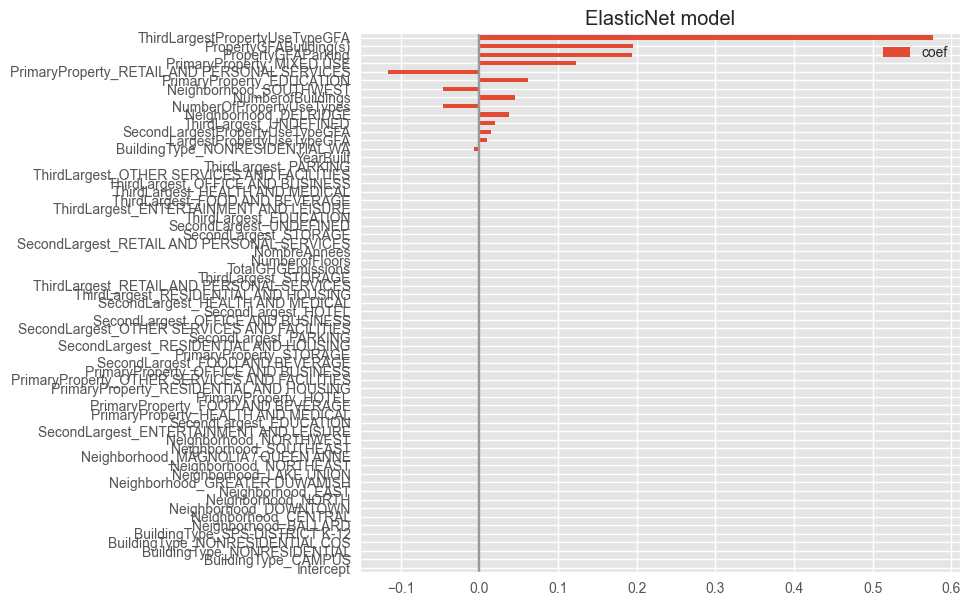

In [249]:
df_feature_importance = pd.DataFrame(grid_search.best_estimator_[-1].coef_.reshape(63,1), columns=["coef"], index=all_column_names)
print(f"Shape: {df_feature_importance.shape}")
(df_feature_importance
 .sort_values("coef", key=lambda v: abs(v), ascending=True)
 .plot(kind="barh", figsize=(10, 7))
)
plt.title("ElasticNet model")
plt.axvline(x=0, color='.6')
plt.subplots_adjust(left=.3);

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Il apparaît clairement que les superficies du parking, du bâtiment, le nombre de bâtiments ainsi que certaines propriétés principales influencent significativement la consommation d'énergie. Nous allons donc tester un modèle en nous concentrant uniquement sur ces variables.</div>

In [250]:
X_index_eln = ['ThirdLargest','ThirdLargestPropertyUseTypeGFA','PrimaryProperty'
               ,'NumberOfPropertyUseTypes','PropertyGFABuilding(s)',
               'PropertyGFAParking','Neighborhood','NumberofBuildings']  # Récupérer les colonnes différentes de "SiteEnergyUse(kBtu)"


# Séparer les caractéristiques (X) et la cible (y) en utilisant iloc
X_train_eln = X_train.loc[:, X_index_eln]

# Séparer les caractéristiques (X) et la cible (y) en utilisant iloc
X_test_eln = X_test.loc[:, X_index_eln]

num_columns_2 = ['ThirdLargestPropertyUseTypeGFA',
               'NumberOfPropertyUseTypes','PropertyGFABuilding(s)',
               'PropertyGFAParking','NumberofBuildings']
obj_columns_2 = ['PrimaryProperty','ThirdLargest','Neighborhood']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('log1p', FunctionTransformer(func=np.log1p))
])

# Création du préprocesseur en utilisant ColumnTransformer
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, obj_columns_2),
        ('num', numeric_transformer, num_columns_2)
    ],remainder='passthrough')

In [252]:
en_pipe_2 = Pipeline(steps=[('preprocessor_2', preprocessor_2),
                           ("regressor", linear_model.ElasticNet()),
                          ]
                   )
en_pipe_2
en_results_2 = train_model(model=en_pipe_2,
                       x_train=X_train_eln, y_train=y_train,
                       x_test=X_test_eln, y_test=y_test)
en_estimator_2 = en_results_2["estimator"]

get_all_performances(value_train=(y_train, en_estimator_2.predict(X_train_eln)),
                     values_test=(y_test, en_estimator_2.predict(X_test_eln)),
                     metrics=METRICS
                    )

Model error: 1.19464


,metric,train,test
0,r2_score,0.266859,0.264938
1,mean_squared_error,1.131407,1.194642
2,mean_absolute_percentage_error,0.055653,0.058418
3,max_error,4.580630,4.806922
4,mean_absolute_error,0.816036,0.845886


In [253]:
param_grid = {
    'regressor__alpha': [0.1, 0.5, 1.0],
    'regressor__l1_ratio': [0.1, 0.5, 0.9],
    'regressor__fit_intercept': [True, False],
    'regressor__max_iter': [1000, 2000, 3000],
    'regressor__tol': [0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(en_pipe_2, param_grid, cv=10, scoring="r2", return_train_score=True)
grid_search
grid_search.fit(X_train_eln, y_train)

best_params = grid_search.best_params_
print(f"Best params: {best_params}")

Best params: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.1, 'regressor__max_iter': 1000, 'regressor__tol': 0.01}


In [255]:

eln_best_model = grid_search.best_estimator_
eln_best_model.fit(X_train_eln, y_train)

# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, eln_best_model.predict(X_train_eln)),
                     values_test=(y_test, eln_best_model.predict(X_test_eln)),
                     metrics=METRICS)

,metric,train,test
0,r2_score,0.632984,0.594059
1,mean_squared_error,0.566391,0.659747
2,mean_absolute_percentage_error,0.038431,0.041188
3,max_error,4.710107,4.453486
4,mean_absolute_error,0.556026,0.588456


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">La  part de variance exppliquée par ce modèle n'est pas élevée et les erreurs bien qu'étant pas différent sur le test et le train sont quand même élevées.</div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>Decision Tree </strong>
</div>  

In [256]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = Pipeline(steps=[('preprocessor', preprocessor),
                           ("regressor", DecisionTreeRegressor()),
                          ]
                   )
dt_reg
dt_results = train_model(model=dt_reg,
                       x_train=X_train, y_train=y_train,
                       x_test=X_test, y_test=y_test)

dt_estimator = dt_results["estimator"]
dt_estimator
# get performances in train & test
get_all_performances(value_train=(y_train, dt_estimator.predict(X_train)),
                     values_test=(y_test, dt_estimator.predict(X_test)),
                     metrics=METRICS
                    )

Model error: 0.35592


,metric,train,test
0,r2_score,1.0,0.781005
1,mean_squared_error,0.0,0.355917
2,mean_absolute_percentage_error,0.0,0.027132
3,max_error,0.0,4.617085
4,mean_absolute_error,0.0,0.399478


<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>Decision Tree :  Optimisation des hyper paramètres</strong>
</div>   

In [257]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Créer un pipeline avec le modèle Decision Tree
dt_pipe = Pipeline(steps=[('preprocessor', preprocessor),
    ("regressor", DecisionTreeRegressor())
])

# Définir la grille des paramètres à rechercher
param_grid = {
    'regressor__max_depth': [None, 5, 10, 15],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=dt_pipe, param_grid=param_grid, cv=5, scoring='r2')

# Exécuter la recherche sur la grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
best_params = grid_search.best_params_
print("Meilleurs paramètres:", best_params)

Meilleurs paramètres: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\P

In [258]:
dt_best_model = grid_search.best_estimator_
dt_best_model.fit(X_train, y_train)

# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, dt_best_model.predict(X_train)),
                     values_test=(y_test, dt_best_model.predict(X_test)),
                     metrics=METRICS)

,metric,train,test
0,r2_score,0.910784,0.581628
1,mean_squared_error,0.137681,0.679950
2,mean_absolute_percentage_error,0.017789,0.041456
3,max_error,1.497432,4.314831
4,mean_absolute_error,0.262966,0.598237


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Les arbres de décision ont tendance à surajuster les données d'entraînement, ce qui explique les faibles erreurs sur le train mais des erreurs plus élevées sur le test.
Cela est dû à la nature flexible de l'arbre qui peut parfaitement s'adapter aux données d'entraînement.</div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>Random forest </strong>
</div>    

In [259]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("regressor", RandomForestRegressor())
])

# Entraîner le modèle Random Forest
rf_results = train_model(model=rf_reg,
                         x_train=X_train, y_train=y_train,
                         x_test=X_test, y_test=y_test)

# Obtenir l'estimateur du modèle Random Forest
rf_estimator = rf_results["estimator"]

# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, rf_estimator.predict(X_train)),
                     values_test=(y_test, rf_estimator.predict(X_test)),
                     metrics=METRICS)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model error: 0.22211


,metric,train,test
0,r2_score,0.985007,0.863337
1,mean_squared_error,0.023138,0.222108
2,mean_absolute_percentage_error,0.007226,0.020509
3,max_error,0.739718,5.154085
4,mean_absolute_error,0.106010,0.300617


<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>Random forest : Optimisation des hyper paramètres</strong>
</div>   

In [260]:
rf_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("regressor", RandomForestRegressor())
])

# Définir la grille des paramètres à rechercher
param_grid = {
    'regressor__n_estimators': [200, 300],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [5, 10],
}

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=5, scoring='r2')

# Exécuter la recherche sur la grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
best_params = grid_search.best_params_
print("Meilleurs paramètres:", best_params)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

Meilleurs paramètres: {'regressor__max_depth': None, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}


In [261]:
# Entraîner le modèle Random Forest avec les meilleurs paramètres trouvés
rf_best_model = grid_search.best_estimator_
rf_best_model.fit(X_train, y_train)

# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, rf_best_model.predict(X_train)),
                     values_test=(y_test, rf_best_model.predict(X_test)),
                     metrics=METRICS)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,metric,train,test
0,r2_score,0.979165,0.867154
1,mean_squared_error,0.032154,0.215905
2,mean_absolute_percentage_error,0.008428,0.020332
3,max_error,0.918994,5.045615
4,mean_absolute_error,0.123543,0.298031


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Le Random Forest est une amélioration par rapport aux modèles Decision Tree.
Il réduit le surajustement grâce à l'agrégation d'arbres indépendants.
Cependant, le modèle reste sensible à l'importance des hyperparamètres comme le nombre d'arbres (n_estimators) et la profondeur maximale.</div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>XGBoost </strong>
</div>  

In [262]:
xgb_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("regressor", XGBRegressor())
])

# Entraîner le modèle XGBoost
xgb_results = train_model(model=xgb_reg,
                          x_train=X_train, y_train=y_train,
                          x_test=X_test, y_test=y_test)

# Obtenir l'estimateur du modèle XGBoost
xgb_estimator = xgb_results["estimator"]

# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, xgb_estimator.predict(X_train)),
                     values_test=(y_test, xgb_estimator.predict(X_test)),
                     metrics=METRICS)

Model error: 0.19575


,metric,train,test
0,r2_score,0.998823,0.879556
1,mean_squared_error,0.001817,0.195749
2,mean_absolute_percentage_error,0.001964,0.022246
3,max_error,0.189428,2.259458
4,mean_absolute_error,0.028552,0.324376


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Le coefficient de détermination (r2_score) est proche de 1 pour l’ensemble d’entraînement, ce qui suggère que le modèle explique bien la variance des données d’entraînement. Cependant, il est légèrement inférieur pour l’ensemble de test, indiquant une légère baisse de performance lors de l’évaluation sur des données non vues pendant l’entraînement. Cela pourrait indiquer un risque de surajustement, mais globalement, le modèle semble bien généraliser.</p>
L’erreur quadratique moyenne (mean_squared_error) est très faible pour l’ensemble d’entraînement, ce qui montre que le modèle offre de bonnes performances prédictives sur ces données. Toutefois, cette erreur est plus élevée sur l’ensemble de test, ce qui suggère que les prédictions du modèle sont moins précises sur de nouvelles données.</div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>XGBoost : Optimisation des hyper paramètres</strong>
</div>

In [263]:
xgb_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("regressor", XGBRegressor())
])

# Définir la grille des paramètres à rechercher
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__min_child_weight': [1, 3, 5]
}

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='r2')

# Exécuter la recherche sur la grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
best_params = grid_search.best_params_
print("Meilleurs paramètres:", best_params)

Meilleurs paramètres: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__min_child_weight': 3, 'regressor__n_estimators': 100}


In [264]:

# Entraîner le modèle XGBoost avec les meilleurs paramètres trouvés
xgb_best_model = grid_search.best_estimator_
xgb_best_model.fit(X_train, y_train)

# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, xgb_best_model.predict(X_train)),
                     values_test=(y_test, xgb_best_model.predict(X_test)),
                     metrics=METRICS)

,metric,train,test
0,r2_score,0.968906,0.900654
1,mean_squared_error,0.047985,0.161460
2,mean_absolute_percentage_error,0.010421,0.019906
3,max_error,0.964597,2.130011
4,mean_absolute_error,0.151647,0.289658


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Le coefficient de détermination (r2_score) est élevé pour les deux ensembles, indiquant que le modèle capture efficacement la variance des données. Bien qu'une légère baisse de performance soit observée entre l'ensemble d'entraînement et l'ensemble de test, le modèle semble généraliser de manière satisfaisante sur des données non vues.</p>
L'erreur quadratique moyenne (mean_squared_error) est plus faible sur l'ensemble d'entraînement que sur l'ensemble de test, ce qui reflète une meilleure précision sur les données d'entraînement. Cependant, les deux valeurs restent acceptables et témoignent de la bonne capacité du modèle à prédire les valeurs cibles.</div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong> Comparaison des modèles</strong>
</div> 

In [265]:
models = [ xgb_best_model, rf_best_model, lr_best_model, eln_best_model, dt_best_model]
model_names = [ 'XGBoost', 'Random Forest', 'Linear Regression', 'ElasticNet', 'Decision Tree']

for model, model_name in zip(models, model_names):
    print("Model:", model_name)
    print(get_all_performances(value_train=(y_train, model.predict(X_train)),
                                values_test=(y_test, model.predict(X_test)),
                                metrics=METRICS))
    print("\n")

Model: XGBoost
                           metric     train      test
0                        r2_score  0.968906  0.900654
1              mean_squared_error  0.047985  0.161460
2  mean_absolute_percentage_error  0.010421  0.019906
3                       max_error  0.964597  2.130011
4             mean_absolute_error  0.151647  0.289658


Model: Random Forest
                           metric     train      test
0                        r2_score  0.979165  0.867154
1              mean_squared_error  0.032154  0.215905
2  mean_absolute_percentage_error  0.008428  0.020332
3                       max_error  0.918994  5.045615
4             mean_absolute_error  0.123543  0.298031


Model: Linear Regression
                           metric     train      test
0                        r2_score  0.897818  0.876198
1              mean_squared_error  0.157691  0.201206
2  mean_absolute_percentage_error  0.020506  0.022257
3                       max_error  2.483542  3.208352
4             mea

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">La comparaison entre ces modèles révèle que XGBoost est le meilleur modèle en termes de variance expliquée et de pourcentage d’erreur, que ce soit sur le jeu de données d’entraînement ou sur le jeu de test.</div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>Enregistrement du modèle</strong>
</div>  

In [266]:
import pickle

# Sauvegarder le modèle dans un fichier
with open('model.pkl', 'wb') as file:
    pickle.dump(xgb_best_model, file)

In [267]:
import joblib

# Sauvegarder le modèle dans un fichier
joblib.dump(xgb_best_model, 'model.joblib')

['model.joblib']

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>Evaluons l'intérêt de EnergyStar_score pour la prediction de la consommation d'énergie</strong>
</div>  

In [268]:
data_2 = pd.read_csv(Path(DATA, "2016_Building_Energy_2.csv"))

In [269]:
df_cat = data_2.select_dtypes(include=['object'])

# Sélectionnez les colonnes numériques
df_num = data_2.select_dtypes(exclude=['object'])

# Concaténez les DataFrames dans le bon ordre
data_2 = pd.concat([df_cat, df_num], axis=1)
X_index = data_2.columns != "SiteEnergyUse(kBtu)"  # Récupérer les colonnes différentes de "SiteEnergyUse(kBtu)"
y_index = data_2.columns == "SiteEnergyUse(kBtu)"  # Récupérer la colonne "SiteEnergyUse(kBtu)"

# Séparer les caractéristiques (X) et la cible (y) en utilisant iloc
X = data_2.iloc[:, X_index]
y = np.log1p(data_2.iloc[:, y_index])

In [270]:
num_columns =  ['PropertyGFAParking',
  'PropertyGFABuilding(s)',
  'LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'ThirdLargestPropertyUseTypeGFA',
  'TotalGHGEmissions',
                'YearBuilt',
                'NumberofBuildings',
                'NumberofFloors',
                'NumberOfPropertyUseTypes',
                'NombreAnnees'
                           
]
obj_columns = list(data_2.select_dtypes(include=['object', 'bool']).columns)
obj_columns,num_columns

(['BuildingType',
  'Neighborhood',
  'PrimaryProperty',
  'SecondLargest',
  'ThirdLargest'],
 ['PropertyGFAParking',
  'PropertyGFABuilding(s)',
  'LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'ThirdLargestPropertyUseTypeGFA',
  'TotalGHGEmissions',
  'YearBuilt',
  'NumberofBuildings',
  'NumberofFloors',
  'NumberOfPropertyUseTypes',
  'NombreAnnees'])

In [271]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [272]:
from sklearn.impute import KNNImputer

# Ajout d'un imputeur KNN pour la variable EnergyStarScore
imputer_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5))  # Vous pouvez ajuster le nombre de voisins selon votre besoin
])

# Ajout de l'imputation KNN dans le préprocesseur existant
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, obj_columns),
        ('num', numeric_transformer, num_columns),
        ('impute', imputer_transformer, ['ENERGYSTARScore'])  # Traitement spécifique pour EnergyStarScore
    ]
)

# Création du pipeline final avec le préprocesseur
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])
final_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BuildingType',
                                                   'Neighborhood',
                                                   'PrimaryProperty',
                                                   'SecondLargest',
                                                   'ThirdLargest']),
                                                 ('num',
                                                  Pipeline(steps=[('log1p',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'TotalGHGEmissions',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'NumberOfPropertyUseTypes',
                                                   'NombreAnnees']),
                                                 ('impute',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['ENERGYSTARScore'])]))])

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>Regression linéaire </strong>
</div>   

In [273]:
from sklearn.feature_selection import RFE

rfe_pipe = Pipeline([
    ("preprocess", final_pipeline),
    ("feature_selection", RFE(estimator=linear_model.LinearRegression(), n_features_to_select=27)),
    ("regressor", linear_model.LinearRegression())
])
rfe_results = train_model(model=rfe_pipe, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test)
rfe_pipe = rfe_results["estimator"]
# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, rfe_pipe.predict(X_train)),
                     values_test=(y_test, rfe_pipe.predict(X_test)),
                     metrics=METRICS)

Model error: 0.20335


,metric,train,test
0,r2_score,0.893773,0.874880
1,mean_squared_error,0.163933,0.203349
2,mean_absolute_percentage_error,0.020939,0.022297
3,max_error,2.548887,3.170350
4,mean_absolute_error,0.303263,0.320138


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Dans l'analyse ci-dessus, nous avons entraîné notre modèle en tenant compte de la variable ENERGYSTARScore, ainsi qu’en sélectionnant uniquement les 10 variables les plus influentes pour la détermination de notre variable cible. Les résultats obtenus sont convaincants, avec une proportion de variance expliquée assez élevée. De plus, les erreurs observées, tant sur le jeu de test que sur le jeu d’entraînement, restent acceptables.</p>
Cependant, il est notable que la réduction du nombre de variables entraîne une légère diminution des performances du modèle. En effet, le modèle initial, sans élimination de variables, avait fourni des résultats légèrement meilleurs, comme illustré ci-dessous.</div>

In [274]:
lr = lr_results["estimator"]
get_all_performances(value_train=(y_train, lr.predict(X_train)),
                     values_test=(y_test, lr.predict(X_test)),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,0.897818,0.876198
1,mean_squared_error,0.157691,0.201206
2,mean_absolute_percentage_error,0.020506,0.022257
3,max_error,2.483542,3.208352
4,mean_absolute_error,0.297025,0.319452


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">En intégrant l'EnergyStarScore, la performance de ce modèle s'améliore nettement à mesure qu'on utilise toutes les variables.</div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>XGBoost </strong>
</div>  

In [275]:
from xgboost import XGBRegressor  # Importez XGBRegressor


rfe_pipe_xgb = Pipeline([
    ("preprocess", final_pipeline),
    ("feature_selection", RFE(estimator=XGBRegressor(), n_features_to_select=10)),
    ("regressor", XGBRegressor())
])


rfe_results_xgb = train_model(model=rfe_pipe_xgb, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test)
rfe_pipe_xgb = rfe_results_xgb["estimator"]

# Affichez les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, rfe_pipe_xgb.predict(X_train)),
                     values_test=(y_test, rfe_pipe_xgb.predict(X_test)),
                     metrics=METRICS)


Model error: 0.15542


,metric,train,test
0,r2_score,0.997824,0.904372
1,mean_squared_error,0.003359,0.155418
2,mean_absolute_percentage_error,0.002533,0.019744
3,max_error,0.344745,1.632287
4,mean_absolute_error,0.036976,0.287473


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">L'intégration de ENERGYSTARScore a amélioré la performance de notre modèle, mais cela comporte un risque de surapprentissage. Tentons de réduire ce risque en optimisant les hyperparamètres, y compris en ajustant le nombre de variables à sélectionner.</div>

In [276]:
param_grid = {
    'feature_selection__n_features_to_select': [10,15,20],  # Nombre de caractéristiques à sélectionner
    'regressor__n_estimators': [100, 200, 300],  # Nombre d'estimateurs dans XGBoost
}

# Initialisez GridSearchCV avec votre pipeline et la grille de paramètres
grid_search = GridSearchCV(estimator=rfe_pipe_xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Effectuez la recherche sur grille
grid_search.fit(X_train, y_train)

# Obtenez le meilleur modèle trouvé
best_model_xbgrfe = grid_search.best_estimator_

In [277]:
get_all_performances(value_train=(y_train, best_model_xbgrfe.predict(X_train)),
                     values_test=(y_test, best_model_xbgrfe.predict(X_test)),
                     metrics=METRICS)

,metric,train,test
0,r2_score,0.999005,0.913423
1,mean_squared_error,0.001535,0.140707
2,mean_absolute_percentage_error,0.001779,0.018679
3,max_error,0.233934,1.668648
4,mean_absolute_error,0.025891,0.272664


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">On voit alors que la part de variance a vraiment augmenté.  Les erreurs ont quant à elle diminué aussi.</div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong> Decision Tree </strong>
</div> 

In [278]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline


dt_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("regressor", DecisionTreeRegressor())
])

rfe_dt_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(estimator=DecisionTreeRegressor(), n_features_to_select=10)),
    ("regressor", DecisionTreeRegressor())
])

rfe_results = train_model(model=rfe_dt_reg, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test)
rfe_estimator = rfe_results["estimator"]

get_all_performances(value_train=(y_train, rfe_estimator.predict(X_train)),
                     values_test=(y_test, rfe_estimator.predict(X_test)),
                     metrics=METRICS)

Model error: 0.34827


,metric,train,test
0,r2_score,1.0,0.785708
1,mean_squared_error,0.0,0.348273
2,mean_absolute_percentage_error,0.0,0.027199
3,max_error,0.0,4.617085
4,mean_absolute_error,0.0,0.399819


In [279]:
param_grid = {
    'feature_selection__n_features_to_select': [10, 15, 20],  # Nombre de caractéristiques à sélectionner
    'regressor__max_depth': [None, 10, 20],  # Profondeur maximale de l'arbre de décision
    'regressor__min_samples_split': [2, 5, 10],  # Nombre minimum d'échantillons requis pour diviser un nœud  # Nombre minimum d'échantillons requis pour être à un nœud feuille
}

# Initialisez GridSearchCV avec votre pipeline et la grille de paramètres
grid_search = GridSearchCV(estimator=rfe_dt_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Effectuez la recherche sur grille
grid_search.fit(X_train, y_train)

# Obtenez le meilleur modèle trouvé
best_model_rfe_dt_reg = grid_search.best_estimator_

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong> Comparaison des modèles</strong>
</div> 

In [280]:
models = [ rfe_pipe_xgb, rfe_pipe, rfe_dt_reg]
model_names = [ 'XGBoost',  'Linear Regression', 'Decision Tree']

for model, model_name in zip(models, model_names):
    print("Model:", model_name)
    print(get_all_performances(value_train=(y_train, model.predict(X_train)),
                                values_test=(y_test, model.predict(X_test)),
                                metrics=METRICS))
    print("\n")

Model: XGBoost
                           metric     train      test
0                        r2_score  0.997824  0.904372
1              mean_squared_error  0.003359  0.155418
2  mean_absolute_percentage_error  0.002533  0.019744
3                       max_error  0.344745  1.632287
4             mean_absolute_error  0.036976  0.287473


Model: Linear Regression
                           metric     train      test
0                        r2_score  0.893773  0.874880
1              mean_squared_error  0.163933  0.203349
2  mean_absolute_percentage_error  0.020939  0.022297
3                       max_error  2.548887  3.170350
4             mean_absolute_error  0.303263  0.320138


Model: Decision Tree
                           metric  train      test
0                        r2_score    1.0  0.785708
1              mean_squared_error    0.0  0.348273
2  mean_absolute_percentage_error    0.0  0.027199
3                       max_error    0.0  4.617085
4             mean_absolute_erro

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Notre meilleur modèle est toujour le XGBoost, nous allons donc l'appliquer à nos données et l'enregistrer comme model2.</div>

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial;font-size:25px; sans-serif; text-align: center;">
    <strong>Enregistrement du modèle</strong>
</div> 

In [281]:
import pickle

# Sauvegarder le modèle dans un fichier
with open('model2.pkl', 'wb') as file:
    pickle.dump(rfe_pipe_xgb, file)

In [282]:
import joblib

# Sauvegarder le modèle dans un fichier
joblib.dump(rfe_pipe_xgb, 'model2.joblib')

['model2.joblib']

<div style="background-color: #D8BFD8; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; font-size:30px; text-align: center;">
    <strong>Quatrième Mission : Réalisation des taches Mlpos pour ce projet</strong>
</div>


In [7]:
pip install xgboost



  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/70/58/2f94976df39470fb00eec2cb4f914dde44cd0df8d96483208bf7db4bc97e/xgboost-2.1.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 435.7 kB/s eta 0:04:47
   ---------------------------------------- 0.0/124.9 MB 435.7 kB/s eta 0:04:47
   ---------------------------------------- 0.1/124.9 MB 416.7 kB/s eta 0:05:00
   ---------------------------------------- 0.1/124.9 MB 416.7 kB/s eta 0:05:00
   ---------------------------------------- 0.2/124.9 MB 579.6 kB/s eta 0:03:36
   ---------------------------------------- 0.2/124.9 MB 620.6 kB/s eta 0:03:21
   ---------------------------------------- 0.3/124.9 MB 684.6 kB/s eta 0:03:03
   ---------------------------------------- 0.3/124.9 MB 813.9 kB/s eta 0:02:34
   ---------

<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Enregistrement du modélé dans le mlflow </div>

In [17]:
import pickle
import mlflow
import mlflow.sklearn
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Étape 1 : Entraîner ou charger le modèle
data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

# Entraînement d'un modèle XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Évaluer le modèle
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle : {accuracy}")

# Définir xgb_best_model
xgb_best_model = xgb_model

# Étape 2 : Sauvegarde du modèle localement
model_path = "model2.pkl"
with open(model_path, 'wb') as file:
    pickle.dump(xgb_best_model, file)

# Étape 3 : Enregistrer dans MLflow
mlflow.set_experiment("MyExperiment")  # Nom de l'expérience
with mlflow.start_run():
    # Log du modèle
    mlflow.log_artifact(model_path, artifact_path="models")
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_param("model_type", "xgboost")
    print("Modèle enregistré dans MLflow avec succès.")



C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:23:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy du modèle : 1.0
Modèle enregistré dans MLflow avec succès.


<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">déploiement du modéle localement </div>

In [3]:
import os

# Chemin du dossier que vous voulez créer
folder_path = "C:/local_deployment/"

# Créer un seul dossier
if not os.path.exists(folder_path):
    os.mkdir(folder_path)
    print(f"Dossier créé : {folder_path}")
else:
    print(f"Le dossier existe déjà : {folder_path}")


Le dossier existe déjà : C:/local_deployment/


In [2]:
import shutil

# Copier le modèle vers un dossier partagé ou accessible localement
local_deployment_path = "C:/local_deployment/"
shutil.copy("model2.pkl", local_deployment_path)
print(f"Modèle déployé localement dans : {local_deployment_path}")


Modèle déployé localement dans : C:/local_deployment/




<div style="background-color: #D3D3D3; color: black; padding: 20px; border-radius: 10px; font-family: Arial, sans-serif; text-align: justify;">Vérification que si le modèle a bien été sauvegardé </div>

In [10]:
import os
import pickle

# Exemple de modèle entraîné
model = "Ceci est un modèle d'exemple"  # Remplacez avec votre modèle entraîné

# Chemin où sauvegarder le modèle
model_dir = "C:/local_deployment/models/"
model_path = os.path.join(model_dir, "model.pkl")

# Créer le répertoire s'il n'existe pas
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Répertoire créé : {model_dir}")

# Sauvegarder le modèle
with open(model_path, 'wb') as file:
    pickle.dump(model, file)

print(f"Modèle sauvegardé avec succès dans : {model_path}")
import os
import pickle

# Exemple de modèle entraîné
model = "Ceci est un modèle d'exemple"  # Remplacez avec votre modèle entraîné

# Chemin où sauvegarder le modèle
model_dir = "C:/local_deployment/models/"
model_path = os.path.join(model_dir, "model.pkl")

# Créer le répertoire s'il n'existe pas
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Répertoire créé : {model_dir}")

# Sauvegarder le modèle
with open(model_path, 'wb') as file:
    pickle.dump(model, file)

print(f"Modèle sauvegardé avec succès dans : {model_path}")


Répertoire créé : C:/local_deployment/models/
Modèle sauvegardé avec succès dans : C:/local_deployment/models/model.pkl
Modèle sauvegardé avec succès dans : C:/local_deployment/models/model.pkl
